In [1]:
import tensorflow as tf
import numpy as np
import ast
import cv2
import json
import network as net
import math
import collections
import os
import sys
import matplotlib.pyplot as plt
from matplotlib.image import imread

C:\Users\JAEKYU\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
img_width = 112
network_output = 14
network_output_width = 14
folder_name = "left_ankle"
def make_batch(img_path, anno_data, batch_size = 16):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    shuffled_anno_data = [anno_data[j] for j in index]
    
    return np.asarray(shuffled_img_data), np.asarray(shuffled_anno_data)
def make_eval_batch(img_path, anno_data, batch_size = 16):
    #num_of_data = len(img_path)
    #index = np.arange(0, num_of_data)
    #np.random.shuffle(index)
    #index = index[:batch_size]
    
    
    
    return np.asarray(img_path), np.asarray(anno_data)
def make_test_batch(img_path, batch_size = 16):
    num_of_data = len(img_path)
    index = np.arange(0, num_of_data)
    np.random.shuffle(index)
    index = index[:batch_size]
    
    shuffled_img_data = [img_path[i] for i in index]
    
    return np.asarray(shuffled_img_data)

def path_to_image(img_path, batch_size):
    #buffer 선언
    image_data = np.zeros((batch_size, img_width, img_width, 3), np.uint8)
    
    index = 0
    for img in (img_path):
        #buffer = cv2.imread(img)
        #buffer = cv2.resize(buffer, (526, 526))
        #image_data[index] = buffer
        #index = index + 1
        #buffer = cv2.resize(buffer, (526, 526))

        image_data[index] = cv2.imread(img)
        index = index + 1

    return image_data

def _put_heatmap_on_plane(heatmap, plane_idx, joint, sigma, height, width, stride):
    start = stride / 2.0 - 0.5

    center_x, center_y = joint

    for g_y in range(height):
        for g_x in range(width):
            x = start + g_x * stride
            y = start + g_y * stride
            d2 = (x-center_x) * (x-center_x) + (y-center_y) * (y-center_y)
            exponent = d2 / 2.0 / sigma / sigma
            if exponent > 4.6052:
                continue

            heatmap[g_y, g_x, plane_idx] += math.exp(-exponent)
            if heatmap[g_y, g_x, plane_idx] > 1.0:
                heatmap[g_y, g_x, plane_idx] = 1.0
                
                
def _put_paf_on_plane(vectormap, countmap, plane_idx, center_from, center_to, threshold, height, width, stride):
    center_from = (center_from[0] // stride, center_from[1] // stride)
    center_to = (center_to[0] // stride, center_to[1] // stride)

    vec_x = center_to[0] - center_from[0]
    vec_y = center_to[1] - center_from[1]

    min_x = max(0, int(min(center_from[0], center_to[0]) - threshold))
    min_y = max(0, int(min(center_from[1], center_to[1]) - threshold))

    max_x = min(width, int(max(center_from[0], center_to[0]) + threshold))
    max_y = min(height, int(max(center_from[1], center_to[1]) + threshold))

    norm = math.sqrt(vec_x ** 2 + vec_y ** 2)
    if norm < 1e-8: #1e-8 이하는 0으로 인식되서 0으로 나눌수 없다는 에러 발생. 따라서 return처리 해줌
        return

    vec_x /= norm
    vec_y /= norm
    
    for x in range(min_x, max_x):
        for y in range(min_y, max_y):
            bec_x = x - center_from[0]
            bec_y = y - center_from[1]
            dist = abs(bec_x * vec_y - bec_y * vec_x)

            if dist > threshold:
                continue

            countmap[x][y][plane_idx] = countmap[x][y][plane_idx] + 1

            vectormap[x][y][plane_idx*2+0] = vec_x
            vectormap[x][y][plane_idx*2+1] = vec_y
            

def bubble_sort(L):
    for i in range(len(L)-1):
        for j in range(len(L)-1):
            if L[j] > L[j+1]:
                temp = L[j+1]
                L[j+1] = L[j]
                L[j] = temp
                
def load_data_path():
    img_path = "./video_with_abstacle/TrainingSet_2/img_another_30/"
    anno_path = "./video_with_abstacle/TrainingSet_2/img_another_30_annotation/"
    
    img_list = os.listdir(img_path)
    anno_list = os.listdir(anno_path)
    
    for index, data in enumerate(img_list):
        img_list[index] = img_path + data
    for index, data in enumerate(anno_list):
        anno_list[index] = anno_path + data
    
    return np.asarray(img_list), np.asarray(anno_list)

def load_data(anno_path, img_path):#아직은 annotation data만 load
    #Annotation Data Load
    f = open(anno_path)
    
    s = f.readlines()

    file_name = []
    parts = []
    _joint_data = []

    
    file_path = []
    joint_data = []
    for index, data in enumerate(s):
        #print(i)
        raw_data = ast.literal_eval(data)
        #print(raw_data)
        raw_data = json.loads(raw_data)
        joint_data.append(raw_data)
    #print(joint_data[0])
    
    heatmap_height = network_output_width
    heatmap_width = network_output_width
    index = 0
    for j in joint_data:
        #print(j)
        height = img_width
        width = img_width
        if(j == {}):
            pass
        else:
            array = j.keys()
            #print(array)
            #print(j)
            for k in array:
                joint_data[index][k][0] = int(j[k][0] / height / 3.17 * heatmap_height)
                joint_data[index][k][1] = int(j[k][1] / width / 3.17 * heatmap_width)#3.17 -> 356/112
                #print(j[k][0], j[k][1])
        index = index + 1
    
    #Image Data Load
    img_data = cv2.imread(img_path)
    img_data = cv2.resize(img_data, (img_width, img_width))

    return joint_data, img_data
def load_test_data():
    path = "./video_with_abstacle/TrainingSet_2/test/output/input/"
    img_list = os.listdir(path)
    
    data = cv2.imread(path)
    data = cv2.resize(data, (112, 112))
    return data

def load_eval_data_path():
    img_path = "./video_with_abstacle/TrainingSet_2/test/image/%s/"%folder_name
    anno_path = "./video_with_abstacle/TrainingSet_2/test/img_anno/"
    
    img_list = os.listdir(img_path)
    anno_list = os.listdir(anno_path)
    
    for index, data in enumerate(img_list):
        img_list[index] = img_path + data
    for index, data in enumerate(anno_list):
        anno_list[index] = anno_path + data
    
    return np.asarray(img_list), np.asarray(anno_list)

In [3]:
class openpose():
    def __init__(self, batch_size, sess):
        self.sess = sess
        self.X = tf.placeholder(dtype=tf.float32, shape=[None, img_width, img_width, 3])
        self.confidence_map_label = tf.placeholder(dtype=tf.float32, shape=[None, network_output, network_output, 17])
        self.vector_map_label = tf.placeholder(dtype=tf.float32, shape=[None, network_output, network_output, 34])
        self.batch_size = batch_size
        self.model()
        self.optimizer()
        print("open pose init complete")
        
    
    def make_heatmap(self, batch_anno_data, width = network_output, height = network_output, num_of_maps = 17):
        batch_size = self.batch_size
        width = network_output
        height = network_output
        num_of_maps = 17
        output = np.zeros((batch_size, width, height, num_of_maps))
        for index, joint_data in enumerate(batch_anno_data):

            heatmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

            for joints in joint_data:
                buffer = list(joints.items())
                key_buffer = joints.keys()

                for i in range(len(buffer)):
                    buffer[i] = list(buffer[i])
                    buffer[i][0] = int(buffer[i][0])
                bubble_sort(buffer)

                idx = 0
                for j in range(17):

                    #print(j)
                    if('%d' %j in key_buffer):
                        center_x = buffer[idx][1][0]
                        center_y = buffer[idx][1][1]
                        #joint = buffer[idx][1]
                        joint = [center_y, center_x]
                        idx = idx + 1
                        _put_heatmap_on_plane(heatmap, plane_idx = j, joint = joint, sigma = 3, height = height, \
                                              width = width, stride = 1)
                    else:
                        pass
                idx = 0
            heatmap[:, :, -1] = np.clip(1.0 - np.amax(heatmap, axis=2), 0.0, 1.0)
            output[index] = heatmap
        return output
        
    
    def make_paf_field(self, batch_joint_data, width = network_output, height = network_output, num_of_maps = 17):
        batch_size = 30
        output1 = np.zeros((batch_size, width, height, num_of_maps*2))
        output2 = np.zeros((batch_size, width, height, num_of_maps))
        for index, joint_data in enumerate(batch_joint_data):
            joint_pairs = list(zip(
                [9, 8, 8, 8,13,14,12,11,7,6,6,3,4,2,1],
                [8,13,12, 7,14,15,11,10,6,3,2,4,5,1,0]))
            #make vector map
            width = network_output
            height = network_output
            num_of_maps = 17
            vectormap = np.zeros((width, height, num_of_maps*2), dtype=np.float32)#batch 일단 뺌
            countmap = np.zeros((width, height, num_of_maps), np.int16)#batch 일단 뺌

            for joints in joint_data:
                key = (joints.keys())
                for plane_idx, (j_idx1, j_idx2) in enumerate(joint_pairs):
                    if(('%d' %j_idx1 in key) and ('%d' %j_idx2 in key)):

                        center_from = joints['%d'%j_idx1]
                        center_to = joints['%d'%j_idx2]

                        if not center_from or not center_to:
                            continue
                        _put_paf_on_plane(vectormap=vectormap, countmap=countmap, plane_idx=plane_idx, center_from=center_from, center_to=center_to, \
                                          threshold=1, height=network_output, width=network_output, stride = 1)

            nonzeros = np.nonzero(countmap)


            for x, y, p in zip(nonzeros[0], nonzeros[1], nonzeros[2]):
                if countmap[x][y][p] <= 0:
                    continue
                vectormap[x][y][p*2+0] /= countmap[x][y][p]
                vectormap[x][y][p*2+1] /= countmap[x][y][p]

            output1[index] = vectormap.astype(np.float32)
            output2[index] = countmap
        return output1, output2 #output1 -> vectormap, output2 -> countmap


        
    
    def model(self):
        stage0_data = net.block_vgg_19(self.X)#stage0_data - None, 58, 58, 512
        
        self.stage1_branch1 = net.block_stage_1_branch1(stage0_data)#stage1_branch1 - None, 58, 58, 34
        self.stage1_branch2 = net.block_stage_1_branch2(stage0_data)#stage1_branch2 - None, 58, 58, 17
        self.stage1_data = tf.concat([self.stage1_branch1, self.stage1_branch2, stage0_data], 3)
        
        self.stage2_branch1 = net.block_stage_2_branch1(self.stage1_data)#stage2_branch1 - None, 58, 58, 34
        self.stage2_branch2 = net.block_stage_2_branch2(self.stage1_data)#stage2_branch2 - None, 58, 58, 17
        self.stage2_data = tf.concat([self.stage2_branch1, self.stage2_branch2, stage0_data], 3)

        self.stage3_branch1 = net.block_stage_3_branch1(self.stage2_data)#stage2_branch1 - None, 58, 58, 34
        self.stage3_branch2 = net.block_stage_3_branch2(self.stage2_data)#stage2_branch2 - None, 58, 58, 17
        self.stage3_data = tf.concat([self.stage3_branch1, self.stage3_branch2, stage0_data], 3)
        
        self.stage4_branch1 = net.block_stage_4_branch1(self.stage3_data)#stage2_branch1 - None, 58, 58, 34
        self.stage4_branch2 = net.block_stage_4_branch2(self.stage3_data)#stage2_branch2 - None, 58, 58, 17
        self.stage4_data = tf.concat([self.stage4_branch1, self.stage4_branch2, stage0_data], 3)
        
        self.stage5_branch1 = net.block_stage_5_branch1(self.stage4_data)#stage2_branch1 - None, 58, 58, 34
        self.stage5_branch2 = net.block_stage_5_branch2(self.stage4_data)#stage2_branch2 - None, 58, 58, 17
        self.stage5_data = tf.concat([self.stage5_branch1, self.stage5_branch2, stage0_data], 3)
        
        self.stage6_branch1 = net.block_stage_6_branch1(self.stage5_data)#stage2_branch1 - None, 58, 58, 34
        self.stage6_branch2 = net.block_stage_6_branch2(self.stage5_data)#stage2_branch2 - None, 58, 58, 17
        self.stage6_data = tf.concat([self.stage6_branch1, self.stage6_branch2, stage0_data], 3)

    def optimizer(self):
        
        W_p = 1
        #loss는 euclid loss 함수 사용
        #affinity field loss - branch1
        self.loss_stage1_branch1 = tf.nn.l2_loss(W_p*(self.stage1_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage2_branch1 = tf.nn.l2_loss(W_p*(self.stage2_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage3_branch1 = tf.nn.l2_loss(W_p*(self.stage3_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage4_branch1 = tf.nn.l2_loss(W_p*(self.stage4_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage5_branch1 = tf.nn.l2_loss(W_p*(self.stage5_branch1 - self.vector_map_label)) / self.batch_size
        self.loss_stage6_branch1 = tf.nn.l2_loss(W_p*(self.stage6_branch1 - self.vector_map_label)) / self.batch_size
        
        #confidence map loss - branch2
        
        self.loss_stage1_branch2 = tf.nn.l2_loss(W_p*(self.stage1_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage2_branch2 = tf.nn.l2_loss(W_p*(self.stage2_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage3_branch2 = tf.nn.l2_loss(W_p*(self.stage3_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage4_branch2 = tf.nn.l2_loss(W_p*(self.stage4_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage5_branch2 = tf.nn.l2_loss(W_p*(self.stage5_branch2 - self.confidence_map_label)) / self.batch_size
        self.loss_stage6_branch2 = tf.nn.l2_loss(W_p*(self.stage6_branch2 - self.confidence_map_label)) / self.batch_size
        
        self.loss1 = tf.reduce_mean([self.loss_stage1_branch1, self.loss_stage1_branch2])
        self.loss2 = tf.reduce_mean([self.loss_stage2_branch1, self.loss_stage2_branch2])
        self.loss3 = tf.reduce_mean([self.loss_stage3_branch1, self.loss_stage3_branch2])
        self.loss4 = tf.reduce_mean([self.loss_stage4_branch1, self.loss_stage4_branch2])
        self.loss5 = tf.reduce_mean([self.loss_stage5_branch1, self.loss_stage5_branch2])
        self.loss6 = tf.reduce_mean([self.loss_stage6_branch1, self.loss_stage6_branch2])
        
        self.total_loss = (self.loss1 + self.loss2 + self.loss3 + self.loss4 + self.loss5 + self.loss6) / self.batch_size
        
        global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 4e-5
        lr = tf.train.exponential_decay(starter_learning_rate, global_step,100000, 0.333, staircase=True)
        self.optimizer_total_loss = tf.train.AdamOptimizer(learning_rate=lr).minimize(self.total_loss, global_step=global_step)
        

    def train(self):
        data_size = 2130#41749
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        h_loss_data = []        
        v_loss_data = []
        
        test_data = load_test_data()
        
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_cmu/Weight.ckpt"
        print("session start")
        #with tf.Session() as sess:
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        print("training data load start")
        self.image_path, self.annotation_path = load_data_path()
        print("training data load finish")
        try:
            saver.restore(self.sess, SAVE_PATH)
            print("load")
        except:
            print("first training")


        for epoch in range(100000):#15
            print("epoch",epoch+1, "start")
            for i in range(total_batch):#total_batch
                #data load, batch 생성
                batch_img_path, batch_annotation_path = make_batch(img_path = self.image_path, anno_data = self.annotation_path, batch_size = batch_size)
                #print(batch_img_path, batch_annotation_path)
                batch_joint = []
                batch_img = []
                for index in range(batch_size):
                    
                    joint_data, img_data = load_data(batch_annotation_path[index], batch_img_path[index])
                    batch_joint.append(joint_data)
                    batch_img.append(img_data)
                
                heatmap = self.make_heatmap(batch_joint, width=network_output, height=network_output, num_of_maps=17)
                vectormap, countmap = self.make_paf_field(batch_joint, width = network_output, height = network_output, num_of_maps = 17)

                total_loss_opt, Heat_loss, Vector_loss = \
                self.sess.run([self.optimizer_total_loss, self.loss_stage6_branch1, self.loss_stage6_branch2],
                         feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap, self.vector_map_label : vectormap})

                h_loss_data.append(Heat_loss)
                v_loss_data.append(Vector_loss)
            if(epoch % 100 == 0):
                heatmap, vectormap = self.sess.run([self.stage6_branch2, self.stage6_branch1], feed_dict={self.X : [test_data]})
                t_heatmap = np.transpose(heatmap, (0, 3, 1, 2))
                t_vectormap = np.transpose(vectormap, (0, 3, 1, 2))
                t_heatmap = np.squeeze(t_heatmap)
                t_vectormap = np.squeeze(t_vectormap)
                buff = np.zeros((14, 14))
                for i in range(16):
                    buff = buff + t_heatmap[i]
                plt.imshow(buff)
                plt.show()
                buff2 = np.zeros((14, 14))
                for i in range(32):
                    buff2 = buff2 + t_vectormap[i]
                plt.imshow(buff2)
                plt.show()
            print("heatmap cost")
            print("Heat_loss : ", Heat_loss)
            print("vectormap cost")
            print("Vector_loss : ", Vector_loss)
            print('\n')

            plt.plot(h_loss_data)
            plt.show()
            plt.plot(v_loss_data)
            plt.show()
            saver.save(self.sess, SAVE_PATH)
        #return batch_img, batch_img_path, batch_annotation, heatmap, vectormap, countmap
        #return self.image_path, self.annotation_data

        



        
    def test(self):
        data_size = 28883#41749
        batch_size = self.batch_size
        total_batch = data_size//batch_size

        self.image_path, self.annotation_path = load_data_path()
        print("training data load finish")

        for epoch in range(1):#15
            print("epoch",epoch+1, "start")
            for i in range(1):#total_batch
                #data load, batch 생성
                batch_img_path, batch_annotation_path = make_batch(img_path = self.image_path, anno_data = self.annotation_path, batch_size = batch_size)
                print(batch_img_path, batch_annotation_path)
                batch_joint = []
                batch_img = []
                for index in range(batch_size):
                    
                    joint_data, img_data = load_data(batch_annotation_path[index], batch_img_path[index])
                    batch_joint.append(joint_data)
                    batch_img.append(img_data)
                #batch_anno, batch_img = load_data(batch_annotation_path, batch_img_path)

                #batch_img, batch_annotation - input data
                batch_annotation_path
                heatmap = self.make_heatmap(batch_joint, width=network_output, height=network_output, num_of_maps=17)
                vectormap, countmap = self.make_paf_field(batch_joint, width = network_output, height = network_output, num_of_maps = 17)
                
                transpose_heatmap = np.transpose(heatmap, (0, 2, 1, 3))
                transpose_vectormap = np.transpose(vectormap, (0, 2, 1, 3))
                """total_loss_opt, Heat_loss, Vector_loss = \
                self.sess.run([self.optimizer_total_loss, self.loss_stage6_branch1, self.loss_stage6_branch2],
                         feed_dict = {self.X : batch_img, self.confidence_map_label : heatmap, self.vector_map_label : vectormap})

                h_loss_data.append(Heat_loss)
                v_loss_data.append(Vector_loss)

            print("heatmap cost")
            print("Heat_loss : ", Heat_loss)
            print("vectormap cost")
            print("Vector_loss : ", Vector_loss)
            print('\n')

            plt.plot(h_loss_data)
            plt.show()
            plt.plot(v_loss_data)
            plt.show()
            saver.save(self.sess, SAVE_PATH)"""
        #batch_img, batch_annotation - input data

        
        return batch_img, transpose_heatmap, transpose_vectormap, countmap
    
    def demo_test(self):
        #print("testing...")
        test_data = load_test_data()
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_cmu/Weight.ckpt"
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        saver.restore(self.sess, SAVE_PATH)
        print("weight load")
        
        heatmap, vectormap = self.sess.run([self.stage6_branch2, self.stage6_branch1], feed_dict={self.X : [test_data]})
        t_heatmap = np.transpose(heatmap, (0, 3, 1, 2))
        t_vectormap = np.transpose(vectormap, (0, 3, 1, 2))
        t_heatmap = np.squeeze(t_heatmap)
        t_vectormap = np.squeeze(t_vectormap)#plt.show()
        return t_heatmap, t_vectormap
    
    def demo_test2(self):
        path = "./video_with_abstacle/TrainingSet_2/test/video/%s/360.avi"%folder_name
        cap = cv2.VideoCapture(path)

        video_data = []
        i = 0
        length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        while(i != length):
            ret, frame = cap.read()
            #gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frame = cv2.resize(frame, (112, 112))
            video_data.append(frame)
            i = i + 1
            
        SAVE_PATH = "C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_cmu/Weight.ckpt"
        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        
        saver.restore(self.sess, SAVE_PATH)
        print("weight load")
        
        heatmap, vectormap = self.sess.run([self.stage6_branch2, self.stage6_branch1], feed_dict={self.X : video_data})
        #여기까지가 CMU output 부분
        img_path, anno_path = load_eval_data_path()
        print(img_path)
        img, anno = make_eval_batch(img_path, anno_path, batch_size=30)
        batch_joint = []
        batch_img = []
        for index in range(30):
            joint2, img2 = load_data(anno[index], img[index])
            batch_joint.append(joint2)
            batch_img.append(img2)
        label_heatmap = self.make_heatmap(batch_joint, width = 14, height = 14, num_of_maps=17)
        label_vectormap, label_countmap = self.make_paf_field(batch_joint, width = 14, height = 14, num_of_maps=17)
        #여기까지가 label data loading 부분
        return video_data, heatmap, vectormap, label_heatmap, label_vectormap
    
    
    
print("cell end")

cell end


open pose init complete
session start
training data load start
training data load finish
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_cmu/Weight.ckpt
first training
epoch 1 start


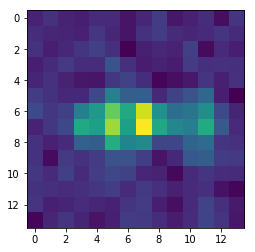

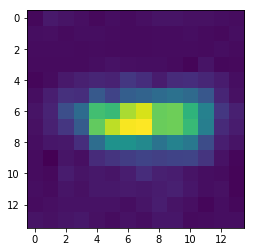

heatmap cost
Heat_loss :  26.636045
vectormap cost
Vector_loss :  10.671328




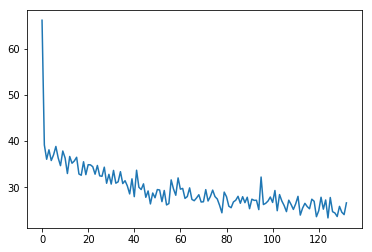

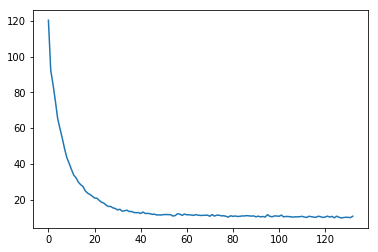

epoch 2 start
heatmap cost
Heat_loss :  19.110191
vectormap cost
Vector_loss :  8.663853




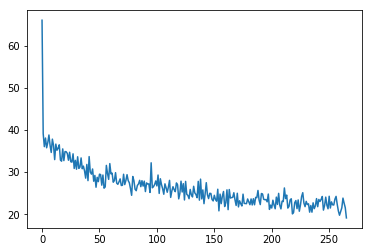

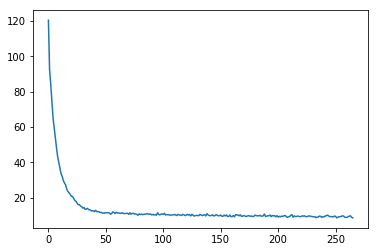

epoch 3 start
heatmap cost
Heat_loss :  20.891268
vectormap cost
Vector_loss :  8.138105




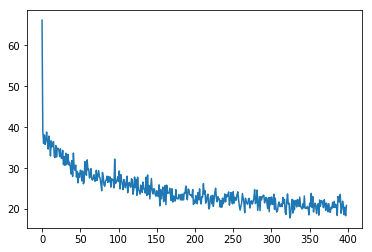

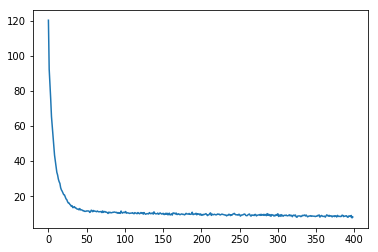

epoch 4 start
heatmap cost
Heat_loss :  19.650623
vectormap cost
Vector_loss :  8.041925




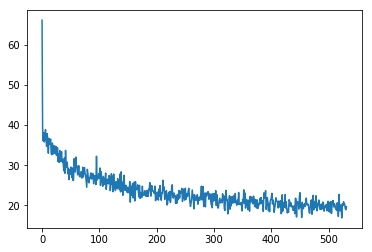

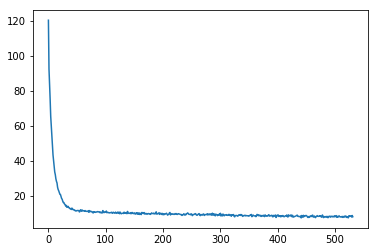

epoch 5 start
heatmap cost
Heat_loss :  20.731125
vectormap cost
Vector_loss :  7.970044




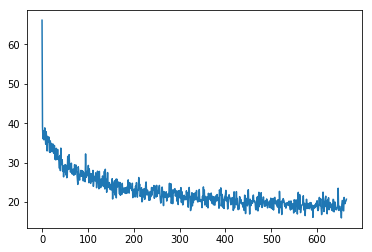

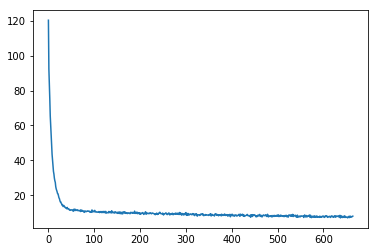

epoch 6 start
heatmap cost
Heat_loss :  17.96355
vectormap cost
Vector_loss :  7.005316




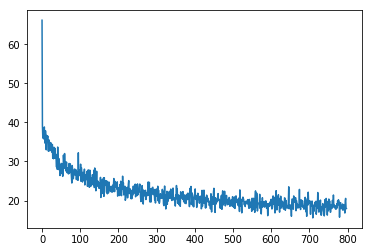

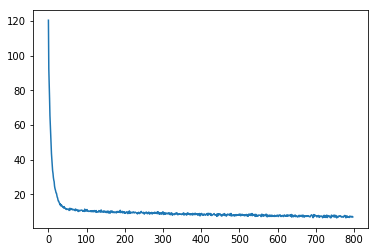

epoch 7 start
heatmap cost
Heat_loss :  16.126427
vectormap cost
Vector_loss :  6.5993614




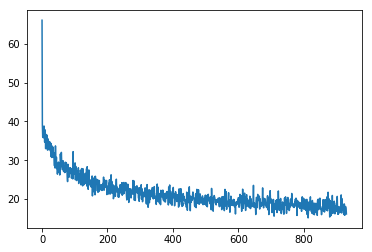

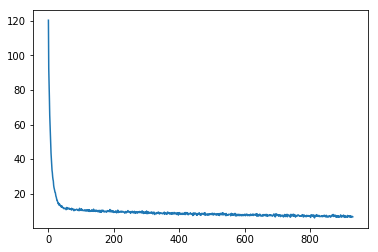

epoch 8 start
heatmap cost
Heat_loss :  15.266691
vectormap cost
Vector_loss :  5.812376




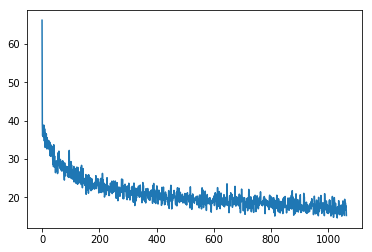

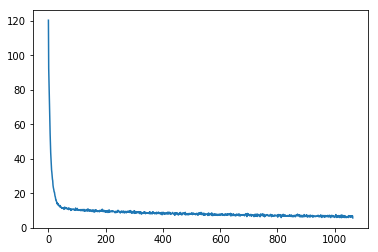

epoch 9 start
heatmap cost
Heat_loss :  15.496612
vectormap cost
Vector_loss :  6.1841693




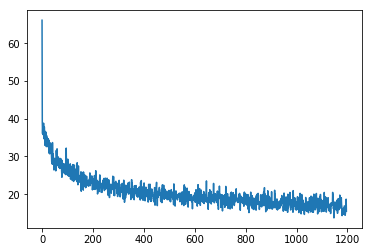

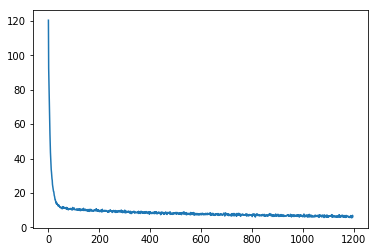

epoch 10 start
heatmap cost
Heat_loss :  16.117498
vectormap cost
Vector_loss :  6.260576




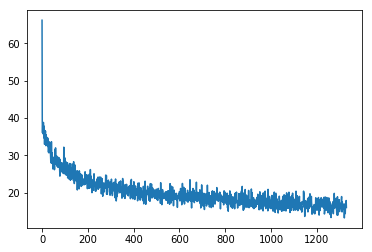

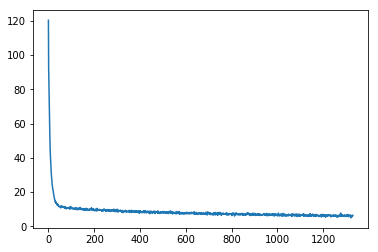

epoch 11 start
heatmap cost
Heat_loss :  14.526931
vectormap cost
Vector_loss :  5.4587297




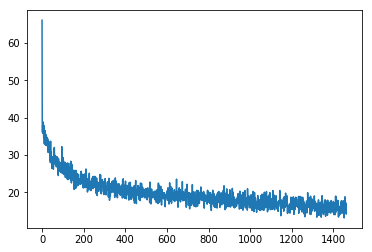

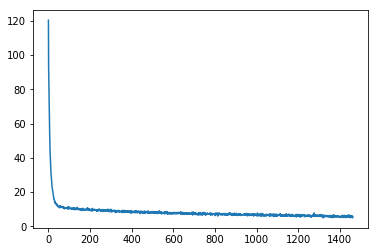

epoch 12 start
heatmap cost
Heat_loss :  15.301153
vectormap cost
Vector_loss :  5.361309




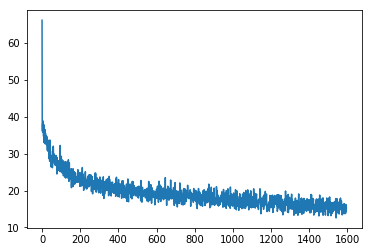

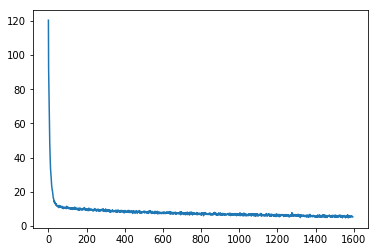

epoch 13 start
heatmap cost
Heat_loss :  12.235957
vectormap cost
Vector_loss :  5.007519




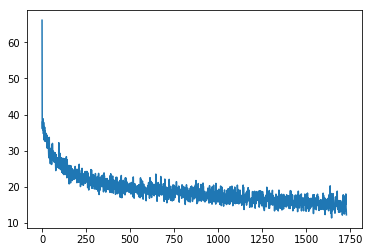

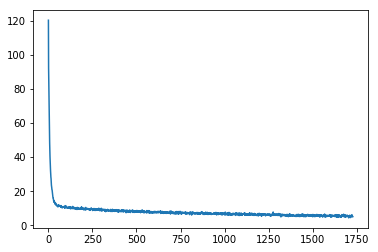

epoch 14 start
heatmap cost
Heat_loss :  14.018463
vectormap cost
Vector_loss :  4.9552536




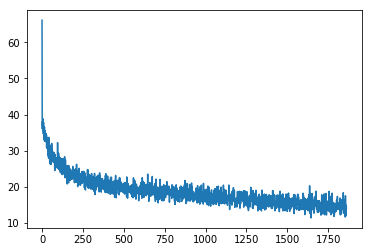

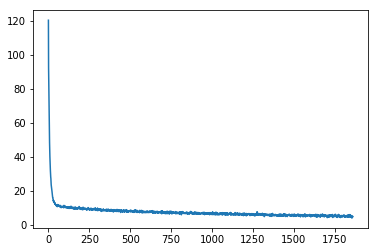

epoch 15 start
heatmap cost
Heat_loss :  13.325363
vectormap cost
Vector_loss :  4.6255074




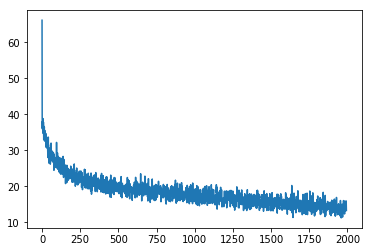

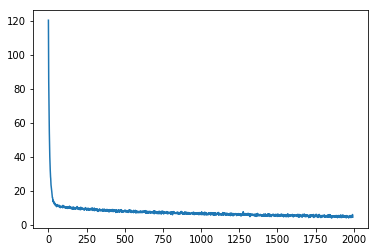

epoch 16 start
heatmap cost
Heat_loss :  13.461161
vectormap cost
Vector_loss :  4.5204277




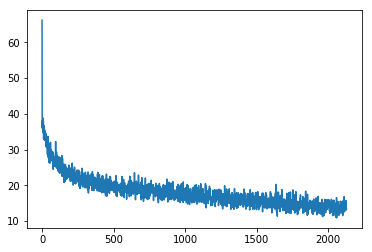

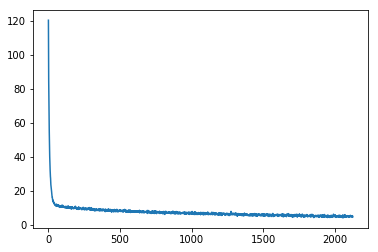

epoch 17 start
heatmap cost
Heat_loss :  14.361607
vectormap cost
Vector_loss :  4.469338




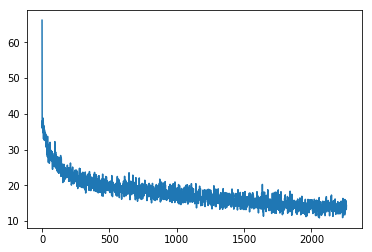

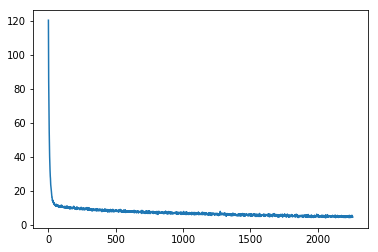

epoch 18 start
heatmap cost
Heat_loss :  13.64743
vectormap cost
Vector_loss :  4.415491




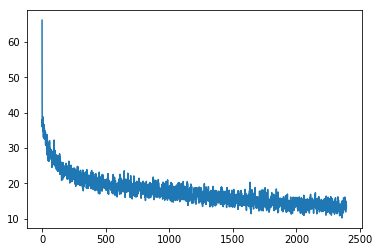

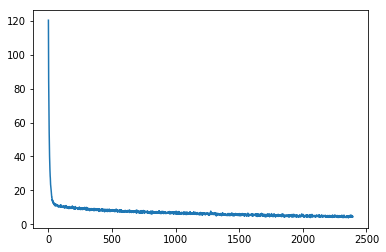

epoch 19 start
heatmap cost
Heat_loss :  11.792342
vectormap cost
Vector_loss :  4.046892




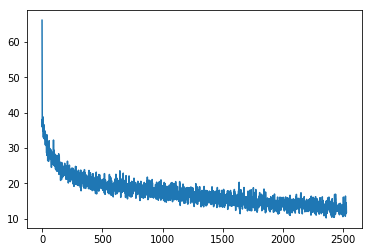

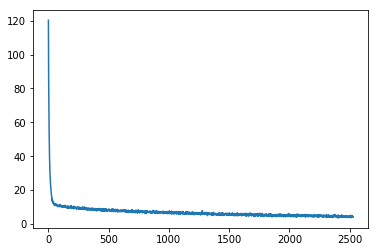

epoch 20 start
heatmap cost
Heat_loss :  10.886967
vectormap cost
Vector_loss :  4.001331




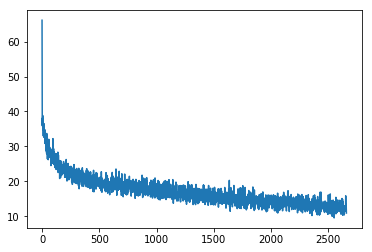

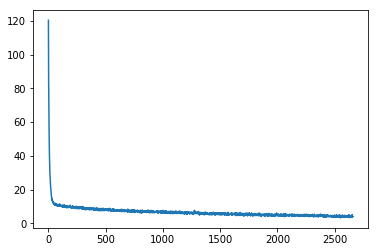

epoch 21 start
heatmap cost
Heat_loss :  10.61278
vectormap cost
Vector_loss :  3.5997906




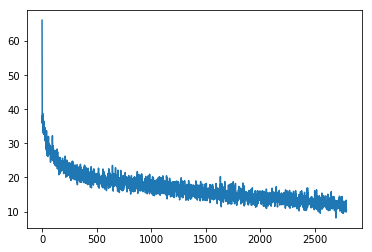

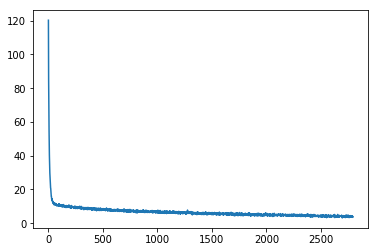

epoch 22 start
heatmap cost
Heat_loss :  10.597567
vectormap cost
Vector_loss :  3.5621355




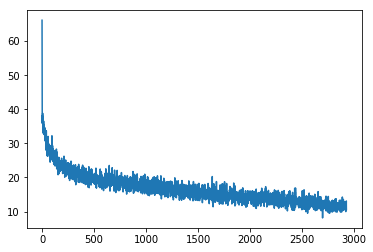

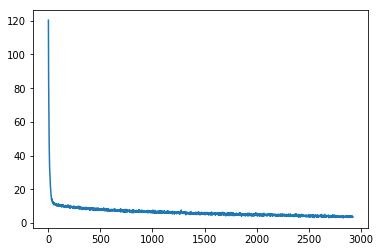

epoch 23 start
heatmap cost
Heat_loss :  11.608881
vectormap cost
Vector_loss :  3.316748




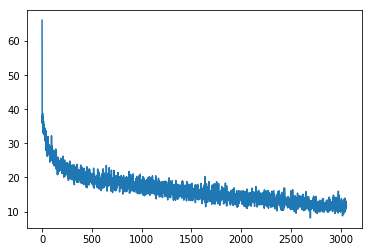

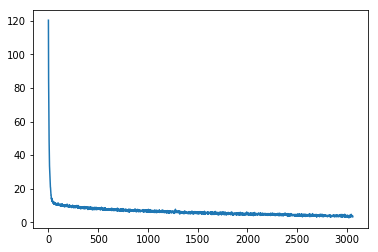

epoch 24 start
heatmap cost
Heat_loss :  9.467665
vectormap cost
Vector_loss :  3.2241209




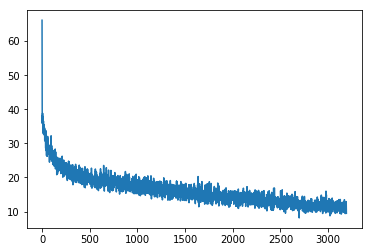

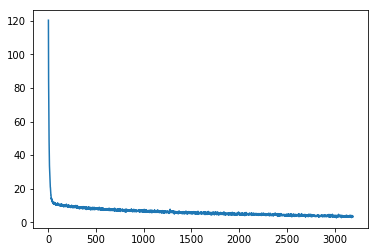

epoch 25 start
heatmap cost
Heat_loss :  9.58596
vectormap cost
Vector_loss :  3.2009141




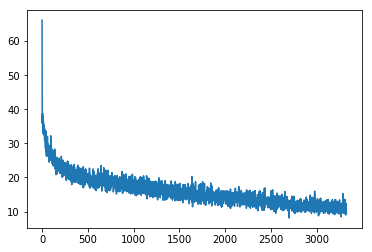

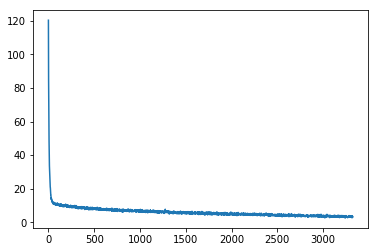

epoch 26 start
heatmap cost
Heat_loss :  10.531674
vectormap cost
Vector_loss :  3.317731




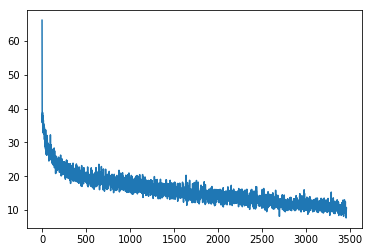

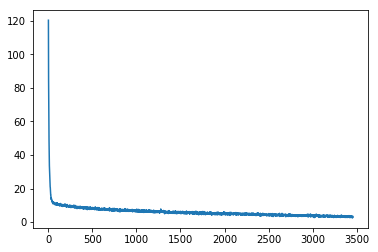

epoch 27 start
heatmap cost
Heat_loss :  10.469947
vectormap cost
Vector_loss :  3.1524763




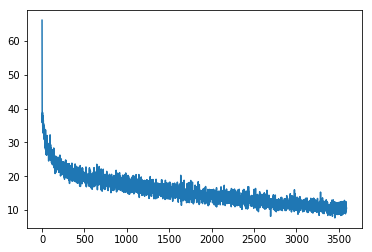

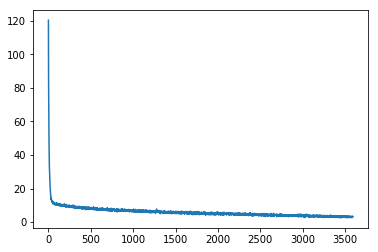

epoch 28 start
heatmap cost
Heat_loss :  11.909075
vectormap cost
Vector_loss :  3.3129215




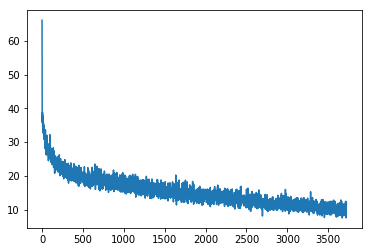

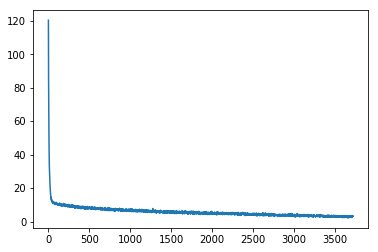

epoch 29 start
heatmap cost
Heat_loss :  11.336853
vectormap cost
Vector_loss :  2.922712




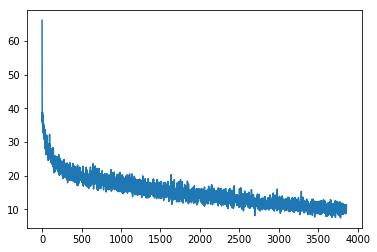

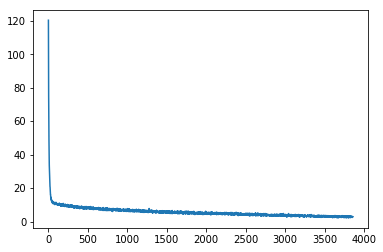

epoch 30 start
heatmap cost
Heat_loss :  10.522341
vectormap cost
Vector_loss :  2.9534736




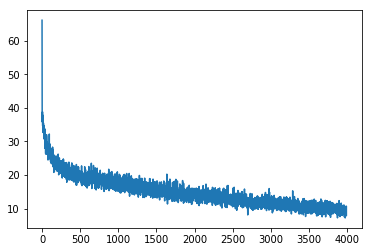

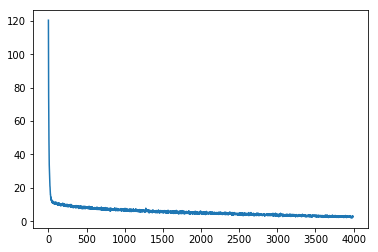

epoch 31 start
heatmap cost
Heat_loss :  9.831195
vectormap cost
Vector_loss :  2.450942




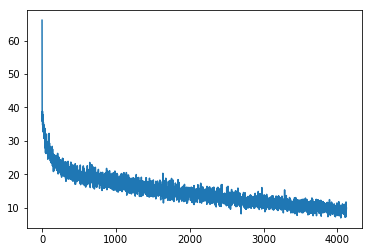

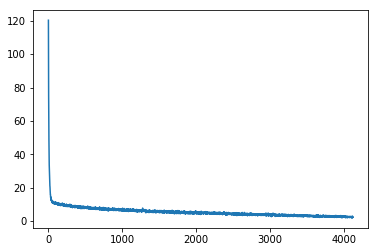

epoch 32 start
heatmap cost
Heat_loss :  8.606052
vectormap cost
Vector_loss :  2.4531207




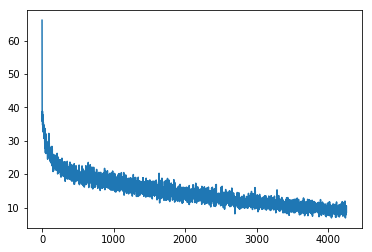

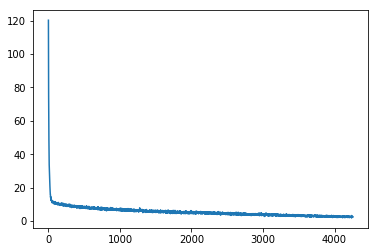

epoch 33 start
heatmap cost
Heat_loss :  8.980019
vectormap cost
Vector_loss :  2.2498636




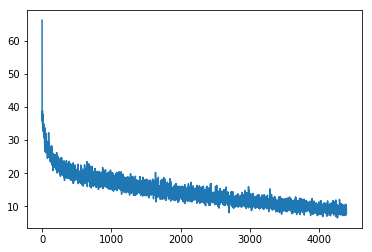

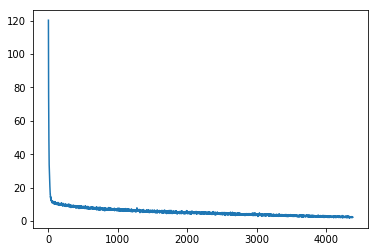

epoch 34 start
heatmap cost
Heat_loss :  7.780136
vectormap cost
Vector_loss :  2.1634867




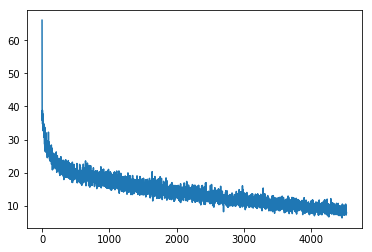

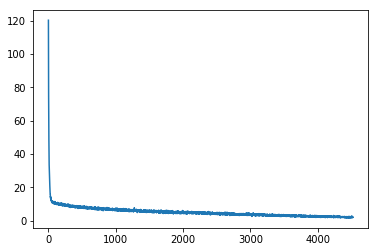

epoch 35 start
heatmap cost
Heat_loss :  9.06293
vectormap cost
Vector_loss :  2.2105758




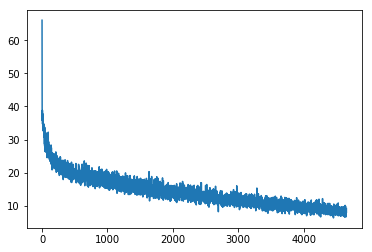

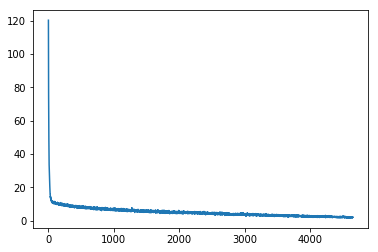

epoch 36 start
heatmap cost
Heat_loss :  9.694067
vectormap cost
Vector_loss :  2.1653516




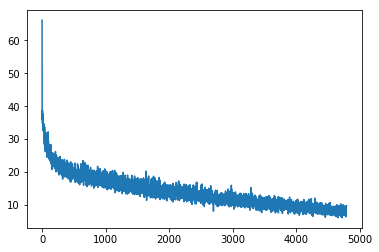

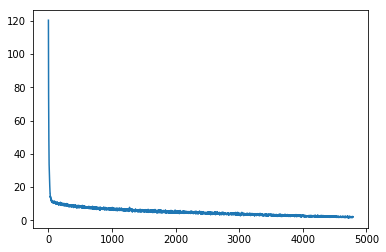

epoch 37 start
heatmap cost
Heat_loss :  8.120786
vectormap cost
Vector_loss :  1.8972623




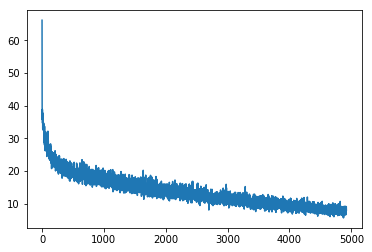

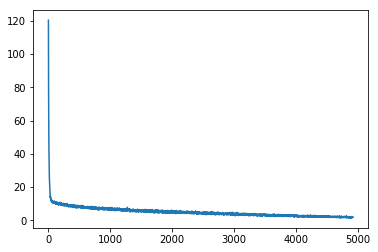

epoch 38 start
heatmap cost
Heat_loss :  8.932106
vectormap cost
Vector_loss :  1.8544575




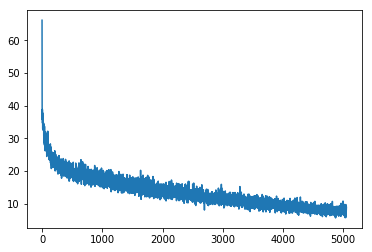

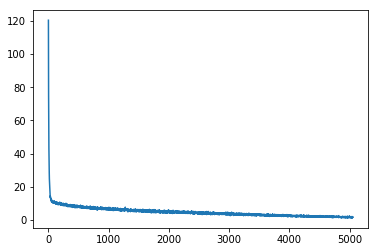

epoch 39 start
heatmap cost
Heat_loss :  5.6581407
vectormap cost
Vector_loss :  1.3105131




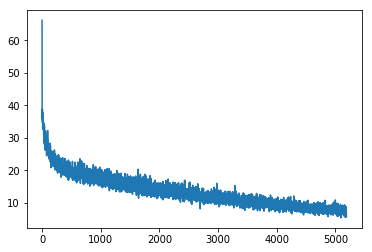

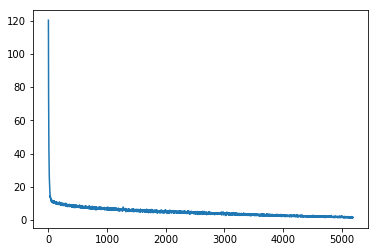

epoch 40 start
heatmap cost
Heat_loss :  7.78416
vectormap cost
Vector_loss :  1.6282852




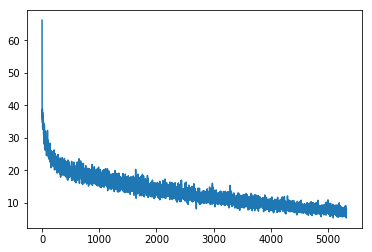

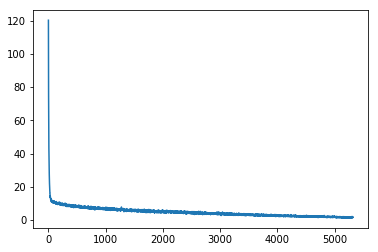

epoch 41 start
heatmap cost
Heat_loss :  6.3585196
vectormap cost
Vector_loss :  1.2642019




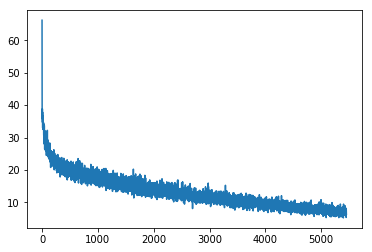

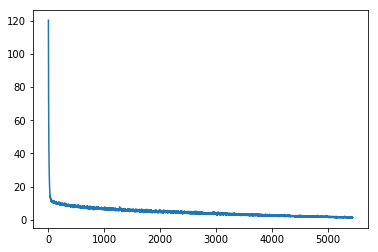

epoch 42 start
heatmap cost
Heat_loss :  6.3061495
vectormap cost
Vector_loss :  1.1561648




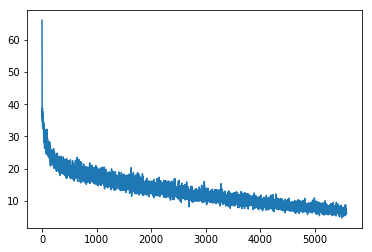

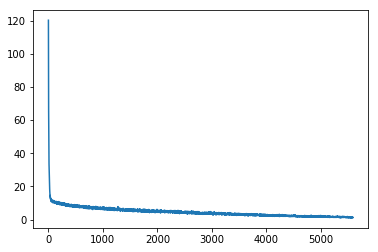

epoch 43 start
heatmap cost
Heat_loss :  7.6319995
vectormap cost
Vector_loss :  1.417353




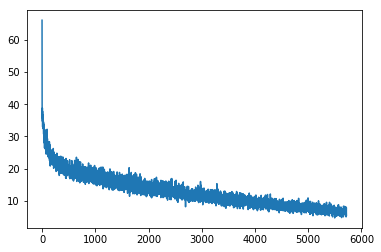

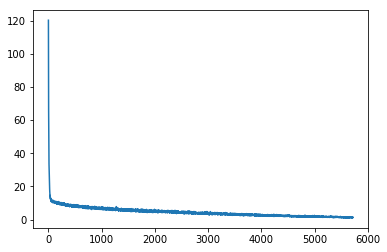

epoch 44 start
heatmap cost
Heat_loss :  6.0829077
vectormap cost
Vector_loss :  1.2548894




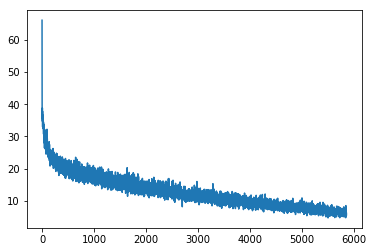

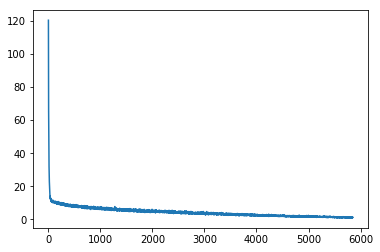

epoch 45 start
heatmap cost
Heat_loss :  7.3325167
vectormap cost
Vector_loss :  1.24751




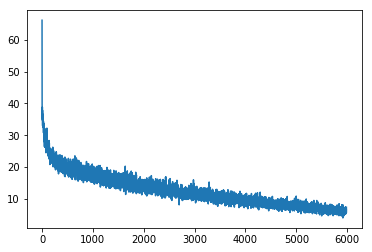

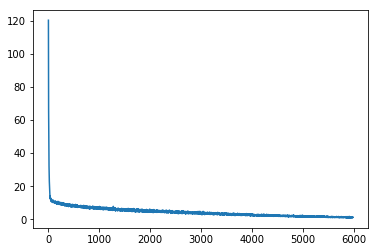

epoch 46 start
heatmap cost
Heat_loss :  6.6555996
vectormap cost
Vector_loss :  1.4230311




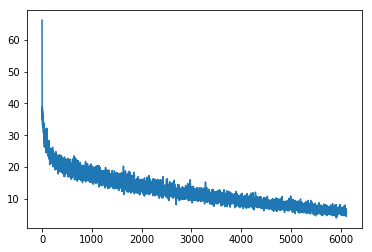

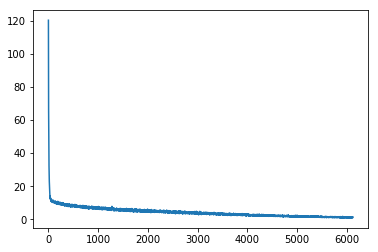

epoch 47 start
heatmap cost
Heat_loss :  6.320656
vectormap cost
Vector_loss :  1.1786995




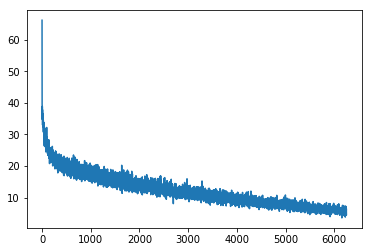

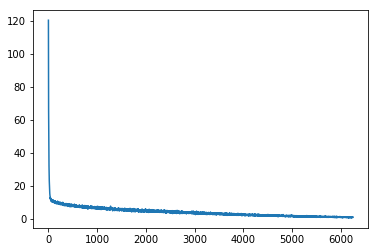

epoch 48 start
heatmap cost
Heat_loss :  4.9375005
vectormap cost
Vector_loss :  0.9773436




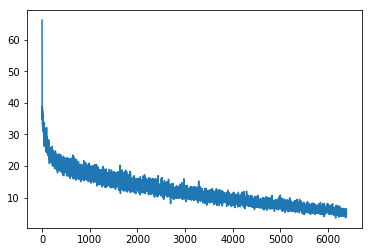

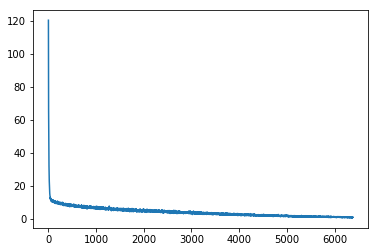

epoch 49 start
heatmap cost
Heat_loss :  4.473037
vectormap cost
Vector_loss :  1.0016198




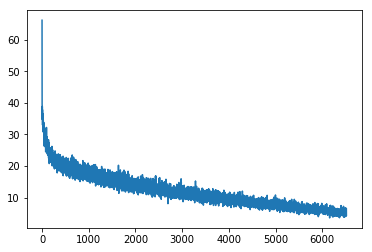

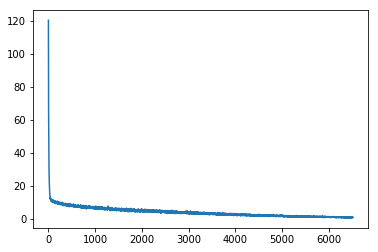

epoch 50 start
heatmap cost
Heat_loss :  4.8837733
vectormap cost
Vector_loss :  0.72711813




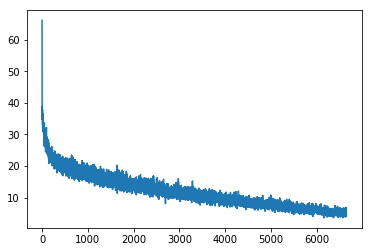

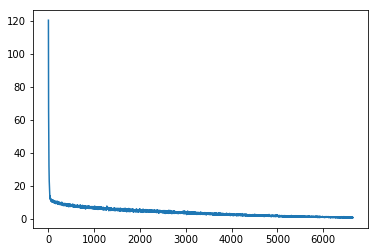

epoch 51 start
heatmap cost
Heat_loss :  5.5806446
vectormap cost
Vector_loss :  1.0061867




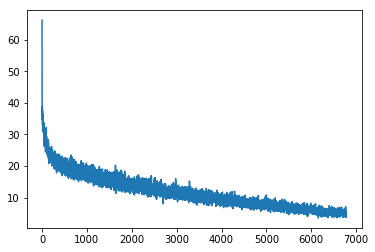

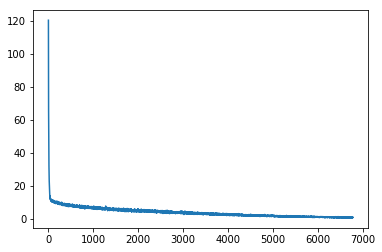

epoch 52 start
heatmap cost
Heat_loss :  4.65403
vectormap cost
Vector_loss :  0.7317412




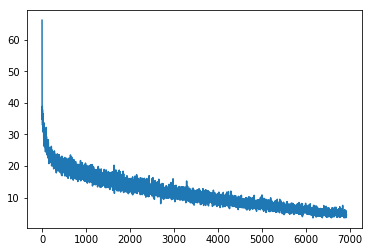

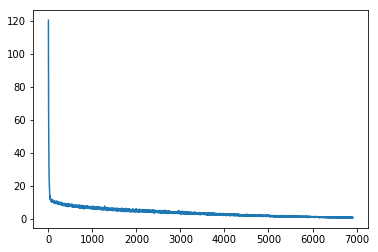

epoch 53 start
heatmap cost
Heat_loss :  4.2304277
vectormap cost
Vector_loss :  0.61491114




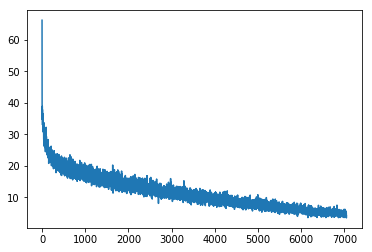

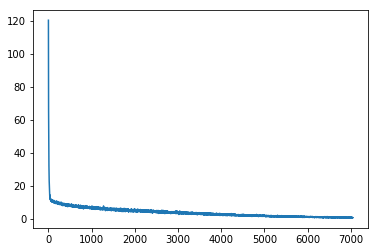

epoch 54 start
heatmap cost
Heat_loss :  3.937045
vectormap cost
Vector_loss :  0.6604062




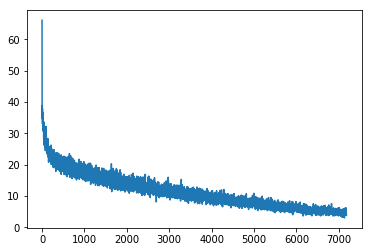

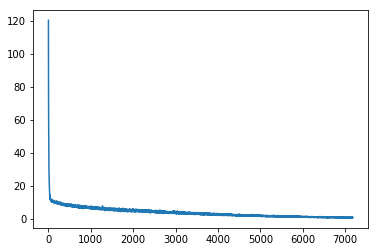

epoch 55 start
heatmap cost
Heat_loss :  3.574011
vectormap cost
Vector_loss :  0.5673951




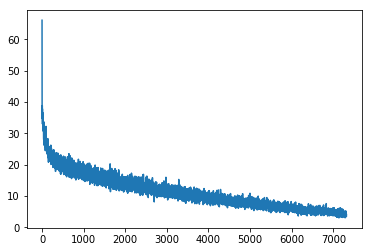

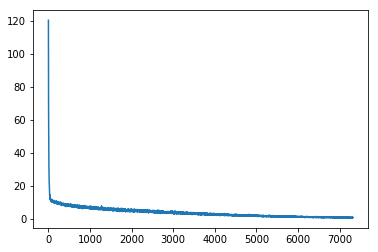

epoch 56 start
heatmap cost
Heat_loss :  4.14262
vectormap cost
Vector_loss :  0.71010196




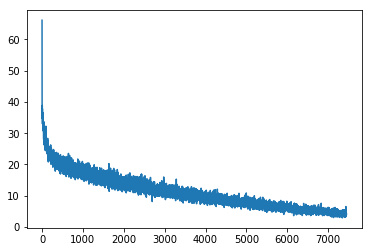

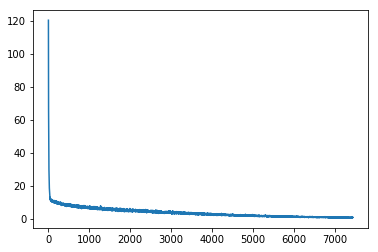

epoch 57 start
heatmap cost
Heat_loss :  3.8807292
vectormap cost
Vector_loss :  0.53255635




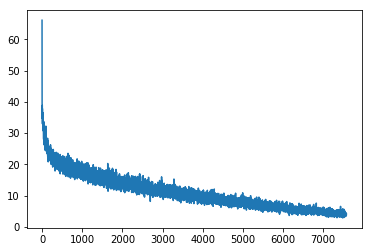

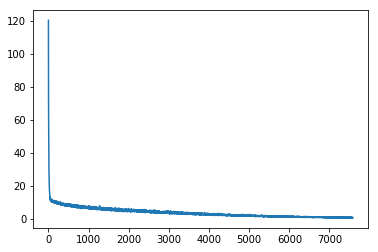

epoch 58 start
heatmap cost
Heat_loss :  4.2374563
vectormap cost
Vector_loss :  0.54355794




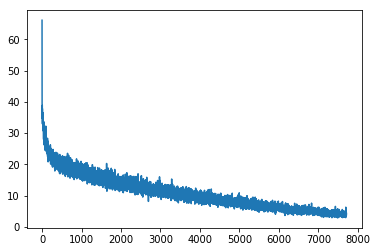

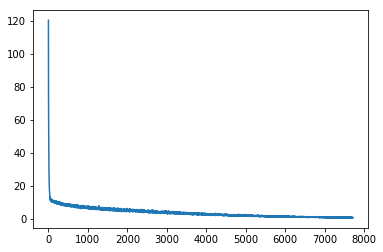

epoch 59 start
heatmap cost
Heat_loss :  4.021598
vectormap cost
Vector_loss :  0.5950593




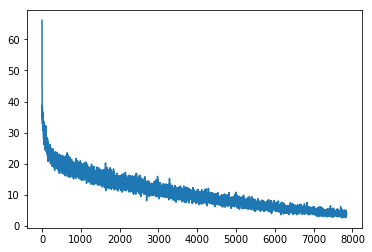

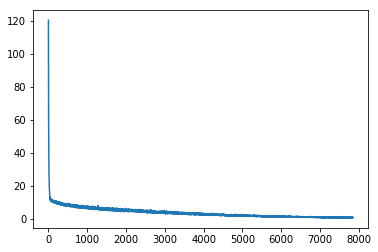

epoch 60 start
heatmap cost
Heat_loss :  3.8684857
vectormap cost
Vector_loss :  0.4711362




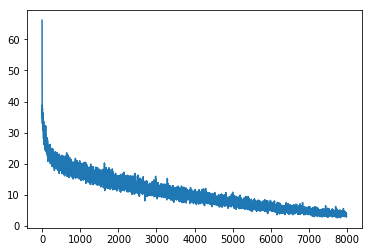

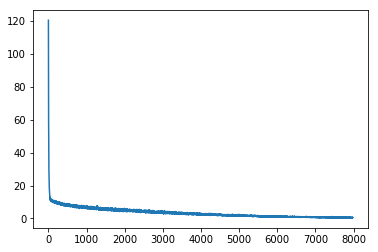

epoch 61 start
heatmap cost
Heat_loss :  3.033987
vectormap cost
Vector_loss :  0.4516794




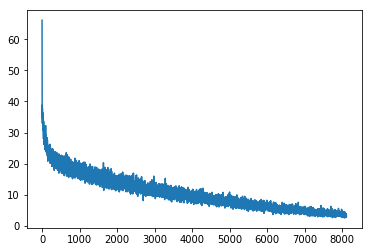

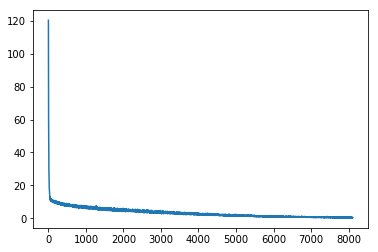

epoch 62 start
heatmap cost
Heat_loss :  3.123568
vectormap cost
Vector_loss :  0.3381933




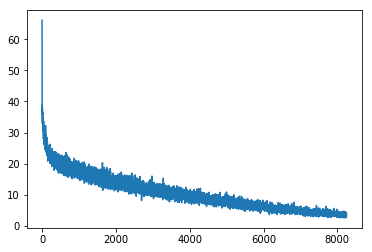

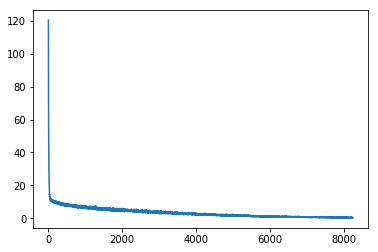

epoch 63 start
heatmap cost
Heat_loss :  3.6443806
vectormap cost
Vector_loss :  0.42464426




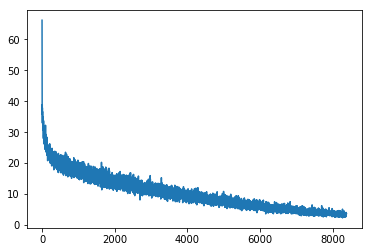

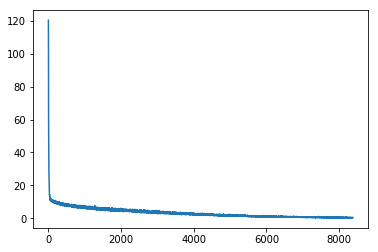

epoch 64 start
heatmap cost
Heat_loss :  2.820458
vectormap cost
Vector_loss :  0.43962646




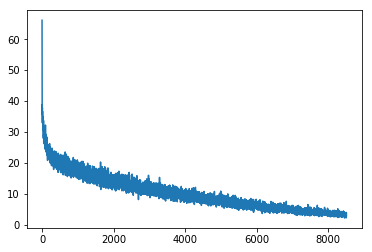

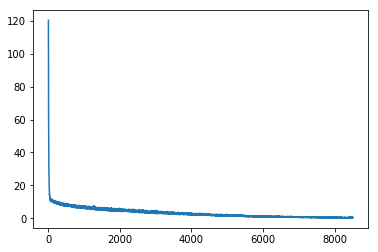

epoch 65 start
heatmap cost
Heat_loss :  3.3316119
vectormap cost
Vector_loss :  0.36290765




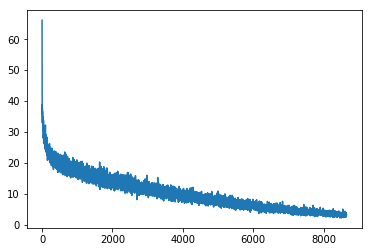

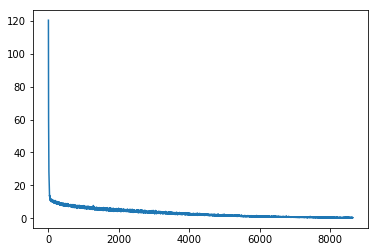

epoch 66 start
heatmap cost
Heat_loss :  2.4754307
vectormap cost
Vector_loss :  0.2983361




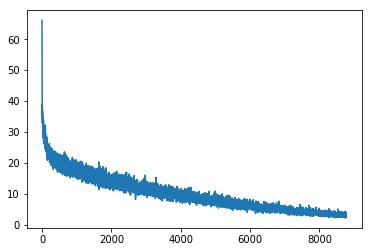

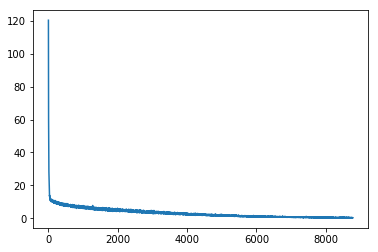

epoch 67 start
heatmap cost
Heat_loss :  3.223569
vectormap cost
Vector_loss :  0.36768973




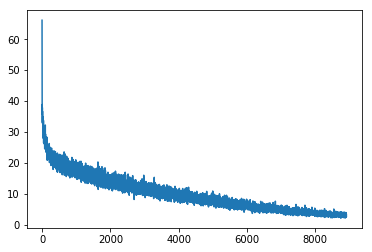

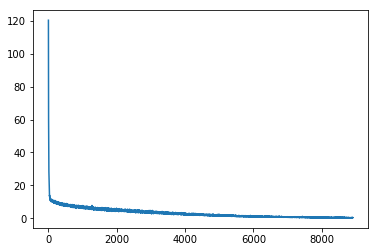

epoch 68 start
heatmap cost
Heat_loss :  2.6208038
vectormap cost
Vector_loss :  0.3143563




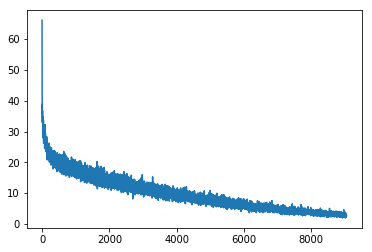

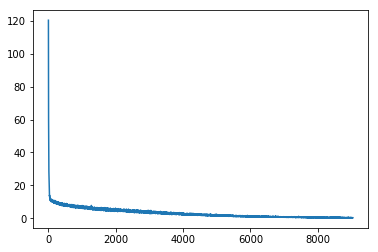

epoch 69 start
heatmap cost
Heat_loss :  2.7585697
vectormap cost
Vector_loss :  0.2952184




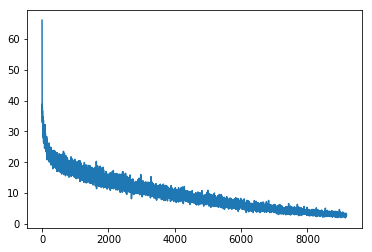

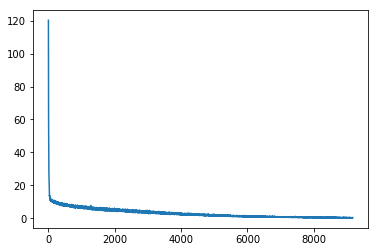

epoch 70 start
heatmap cost
Heat_loss :  2.7277215
vectormap cost
Vector_loss :  0.25306064




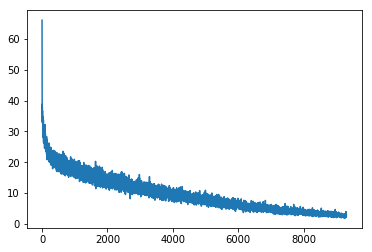

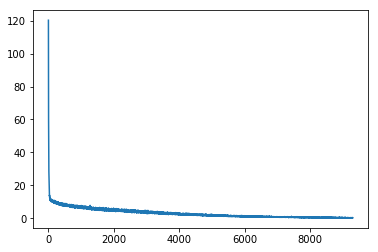

epoch 71 start
heatmap cost
Heat_loss :  2.4028642
vectormap cost
Vector_loss :  0.25010118




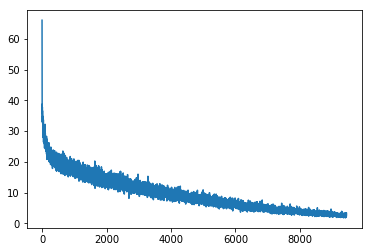

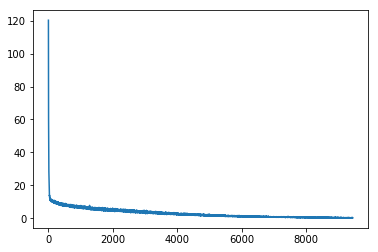

epoch 72 start
heatmap cost
Heat_loss :  2.2780528
vectormap cost
Vector_loss :  0.28426918




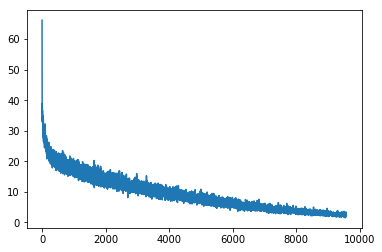

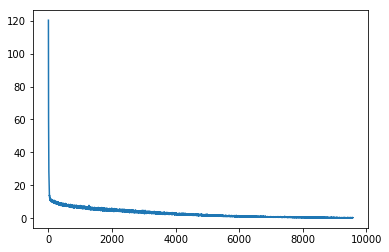

epoch 73 start
heatmap cost
Heat_loss :  2.2434409
vectormap cost
Vector_loss :  0.24058515




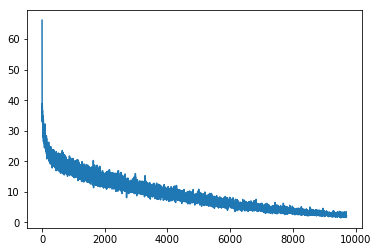

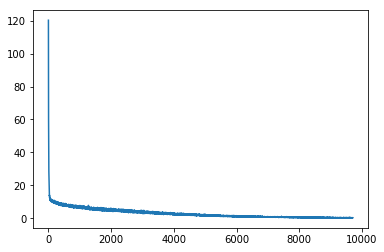

epoch 74 start
heatmap cost
Heat_loss :  2.5172987
vectormap cost
Vector_loss :  0.2765996




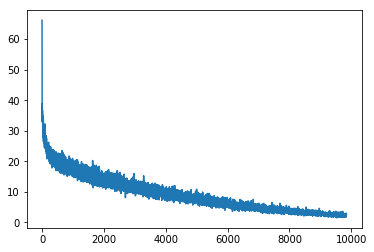

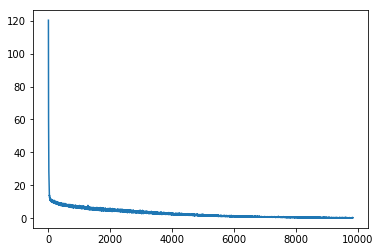

epoch 75 start
heatmap cost
Heat_loss :  2.0534
vectormap cost
Vector_loss :  0.33908117




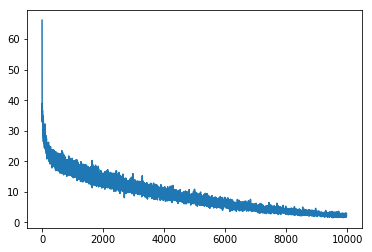

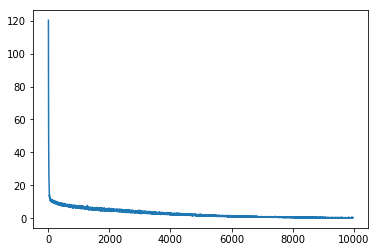

epoch 76 start
heatmap cost
Heat_loss :  2.2085779
vectormap cost
Vector_loss :  0.23812559




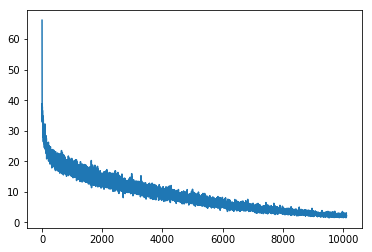

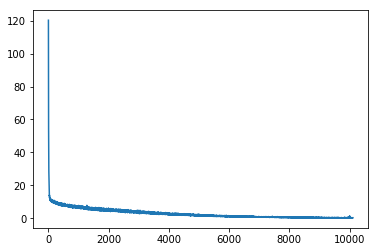

epoch 77 start
heatmap cost
Heat_loss :  1.9569775
vectormap cost
Vector_loss :  0.23385501




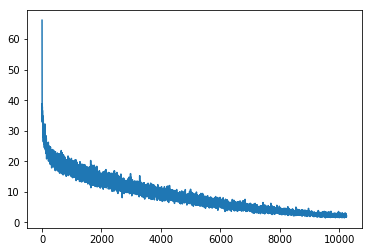

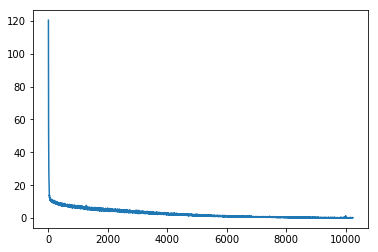

epoch 78 start
heatmap cost
Heat_loss :  2.020679
vectormap cost
Vector_loss :  0.19209446




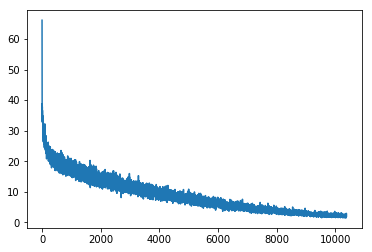

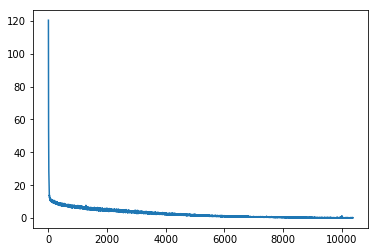

epoch 79 start
heatmap cost
Heat_loss :  1.6783696
vectormap cost
Vector_loss :  0.15537894




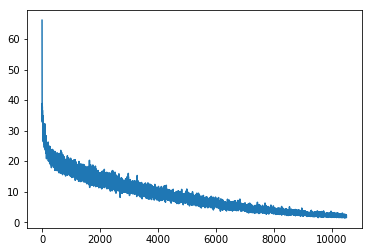

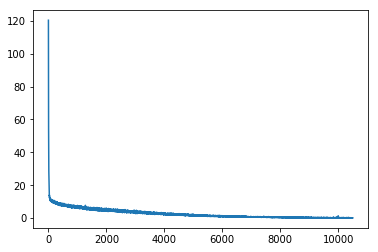

epoch 80 start
heatmap cost
Heat_loss :  2.050977
vectormap cost
Vector_loss :  0.18173519




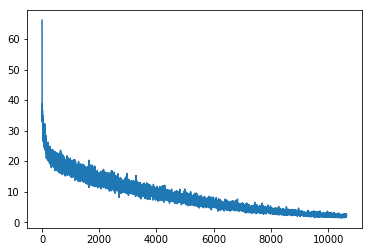

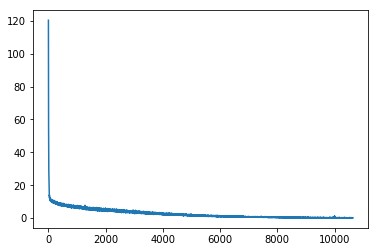

epoch 81 start
heatmap cost
Heat_loss :  2.5506873
vectormap cost
Vector_loss :  0.2772379




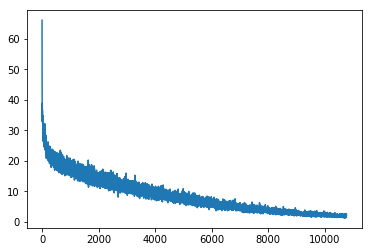

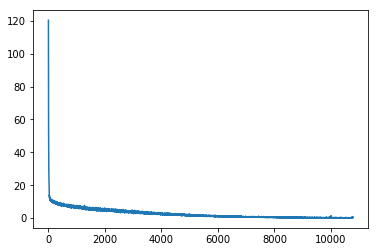

epoch 82 start
heatmap cost
Heat_loss :  1.441405
vectormap cost
Vector_loss :  0.13498187




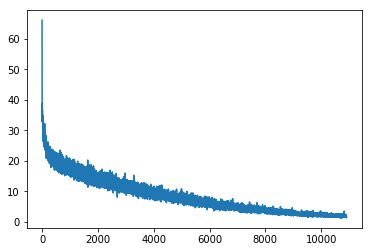

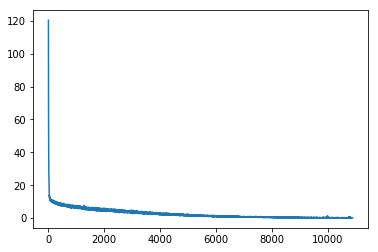

epoch 83 start
heatmap cost
Heat_loss :  1.958528
vectormap cost
Vector_loss :  0.12815091




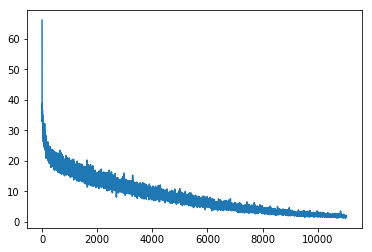

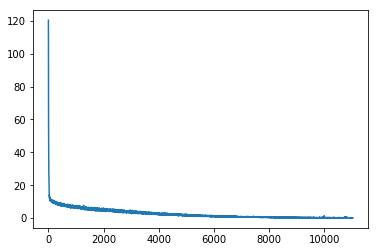

epoch 84 start
heatmap cost
Heat_loss :  2.0744264
vectormap cost
Vector_loss :  0.17637876




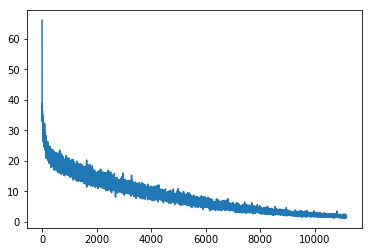

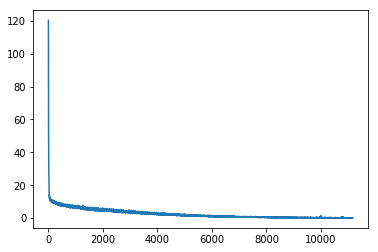

epoch 85 start
heatmap cost
Heat_loss :  1.8650749
vectormap cost
Vector_loss :  0.29122874




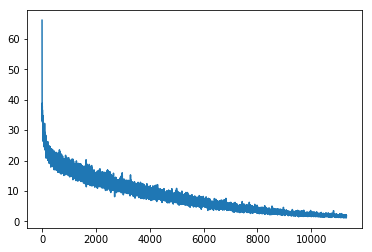

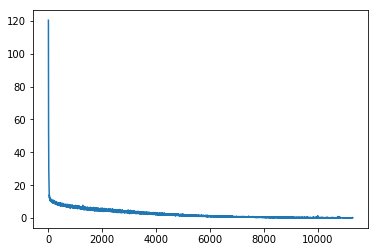

epoch 86 start
heatmap cost
Heat_loss :  1.565743
vectormap cost
Vector_loss :  0.17901953




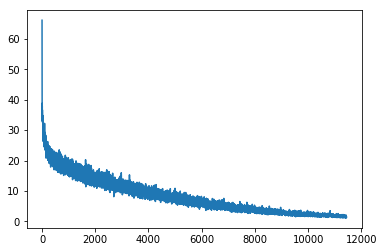

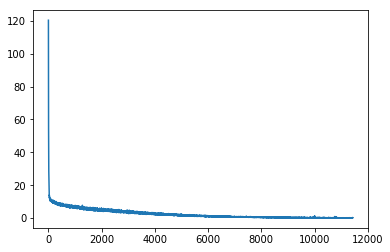

epoch 87 start
heatmap cost
Heat_loss :  1.9462454
vectormap cost
Vector_loss :  0.11791997




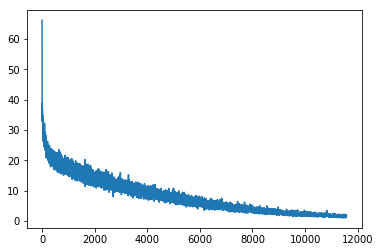

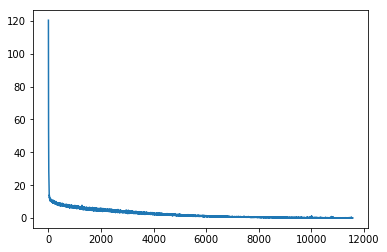

epoch 88 start
heatmap cost
Heat_loss :  1.3502553
vectormap cost
Vector_loss :  0.10391818




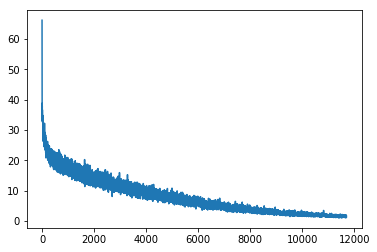

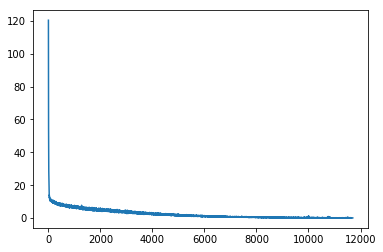

epoch 89 start
heatmap cost
Heat_loss :  1.4453062
vectormap cost
Vector_loss :  0.1264942




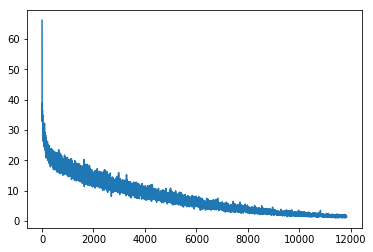

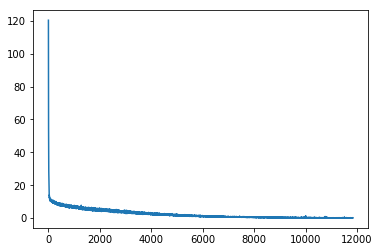

epoch 90 start
heatmap cost
Heat_loss :  1.5916153
vectormap cost
Vector_loss :  0.109127015




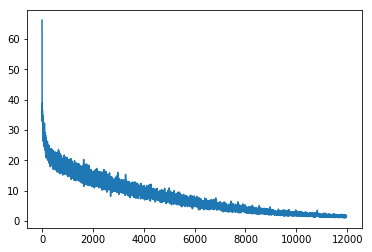

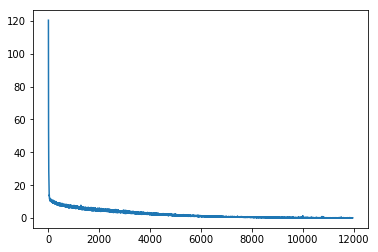

epoch 91 start
heatmap cost
Heat_loss :  1.2505789
vectormap cost
Vector_loss :  0.15467615




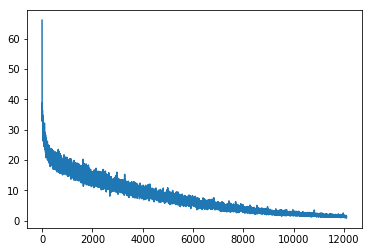

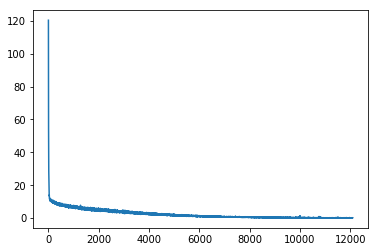

epoch 92 start
heatmap cost
Heat_loss :  1.0942129
vectormap cost
Vector_loss :  0.104709834




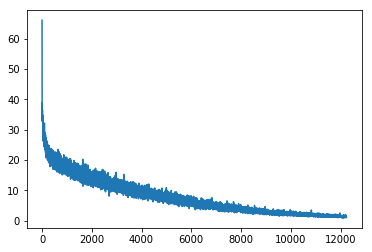

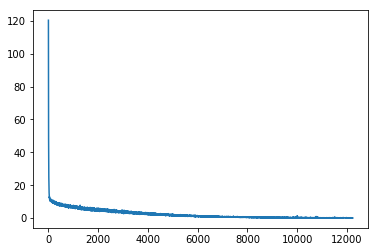

epoch 93 start
heatmap cost
Heat_loss :  1.4523454
vectormap cost
Vector_loss :  0.13657856




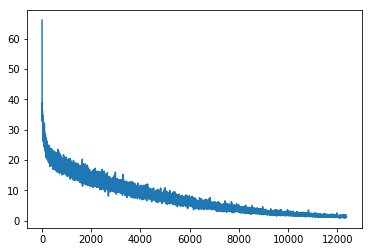

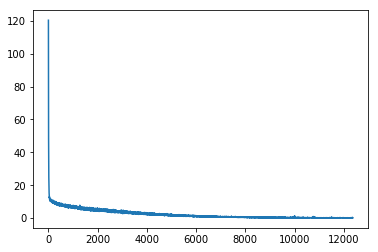

epoch 94 start
heatmap cost
Heat_loss :  1.4807202
vectormap cost
Vector_loss :  0.09972567




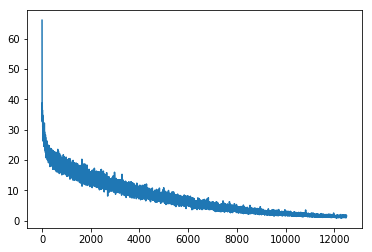

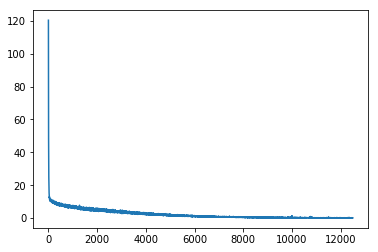

epoch 95 start
heatmap cost
Heat_loss :  0.9837549
vectormap cost
Vector_loss :  0.15123442




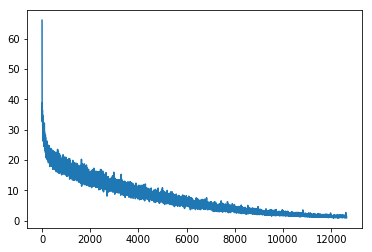

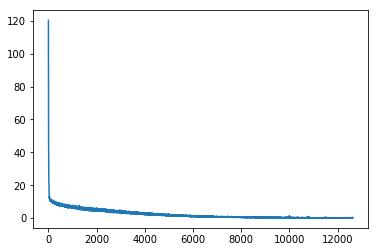

epoch 96 start
heatmap cost
Heat_loss :  1.2670385
vectormap cost
Vector_loss :  0.11708237




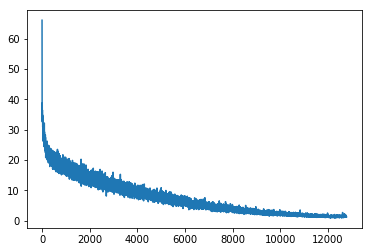

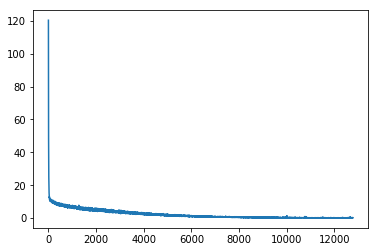

epoch 97 start
heatmap cost
Heat_loss :  1.1146321
vectormap cost
Vector_loss :  0.084291525




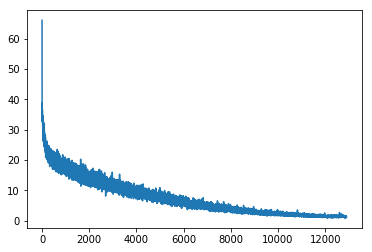

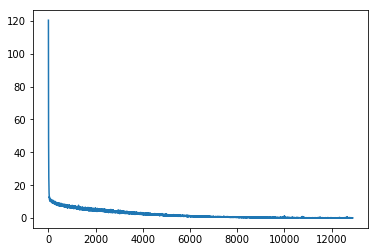

epoch 98 start
heatmap cost
Heat_loss :  1.0831847
vectormap cost
Vector_loss :  0.09425901




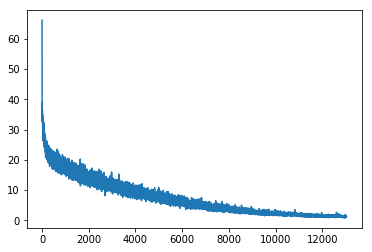

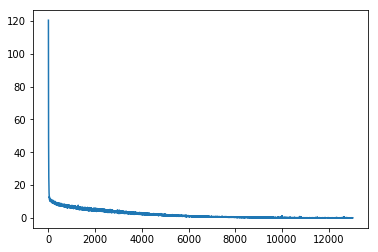

epoch 99 start
heatmap cost
Heat_loss :  1.1110632
vectormap cost
Vector_loss :  0.0815355




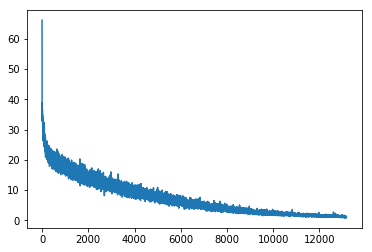

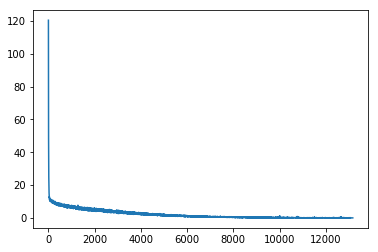

epoch 100 start
heatmap cost
Heat_loss :  1.1073954
vectormap cost
Vector_loss :  0.14594257




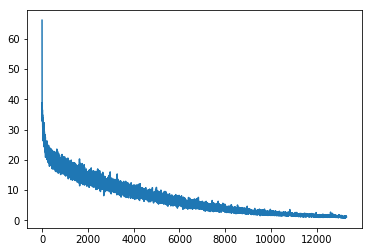

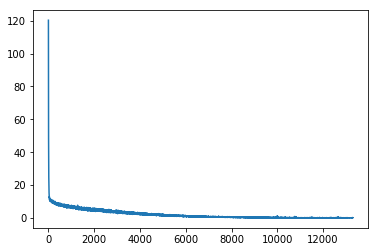

epoch 101 start


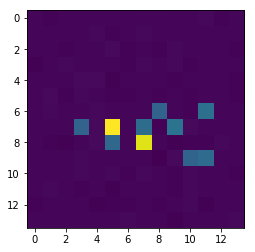

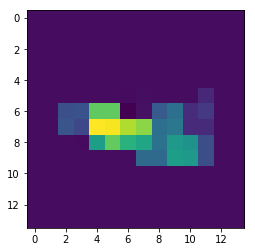

heatmap cost
Heat_loss :  1.0568867
vectormap cost
Vector_loss :  0.10420612




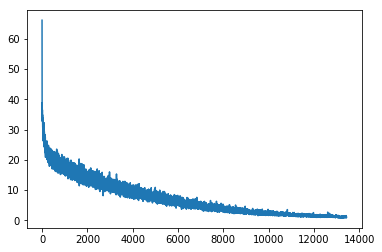

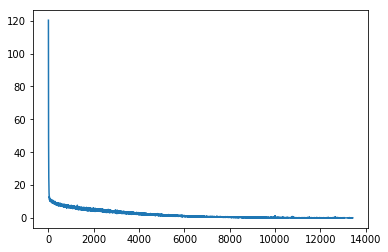

epoch 102 start


KeyboardInterrupt: 

In [4]:
with tf.Session() as sess:
    obj = openpose(batch_size=16, sess = sess)
    #batch_img, batch_img_path, stage_output4, \
#stage_output5, stage_output6, _stage_output4, _stage_output5, _stage_output6 = obj.test()
    obj.train()

input data test

open pose init complete
training data load finish
epoch 1 start
['./video_with_abstacle/TrainingSet_2/img_another_30/866.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/1373.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/1877.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/1142.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/1184.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/2091.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/819.jpg'
 './video_with_abstacle/TrainingSet_2/img_another_30/73.jpg'] ['./video_with_abstacle/TrainingSet_2/img_another_30_annotation/866.json'
 './video_with_abstacle/TrainingSet_2/img_another_30_annotation/1373.json'
 './video_with_abstacle/TrainingSet_2/img_another_30_annotation/1877.json'
 './video_with_abstacle/TrainingSet_2/img_another_30_annotation/1142.json'
 './video_with_abstacle/TrainingSet_2/img_another_30_annotation/1184.json'
 './video_with_abstacle/TrainingSet_2/img_another_30_annotati

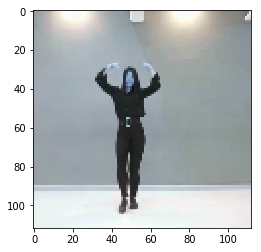

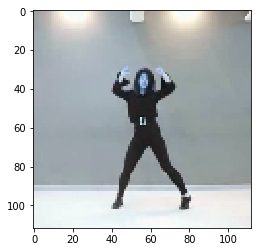

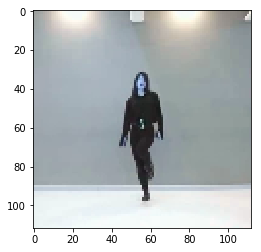

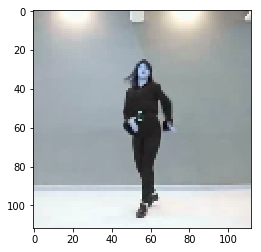

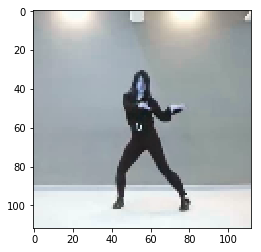

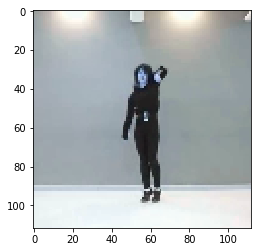

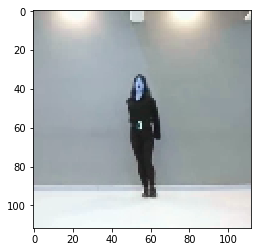

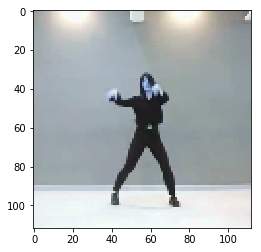

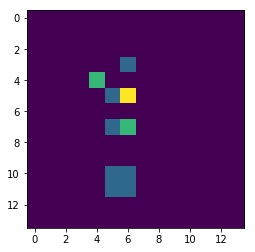

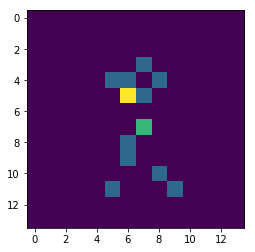

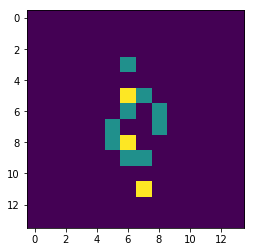

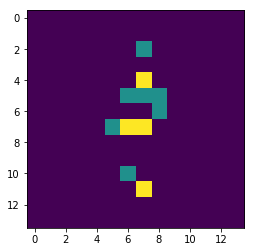

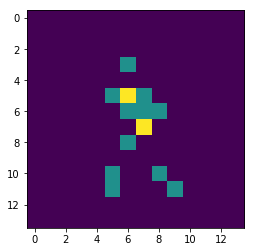

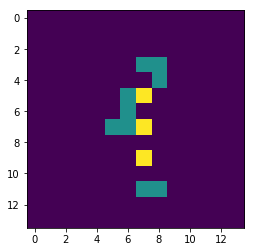

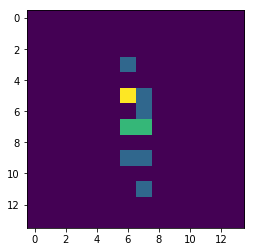

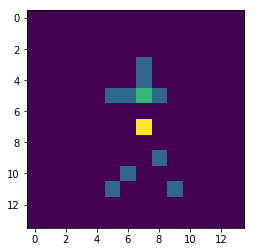

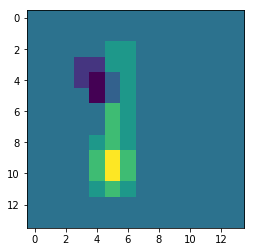

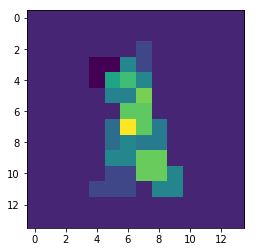

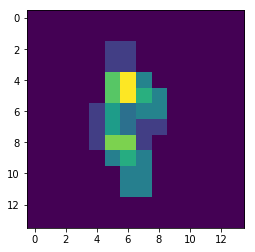

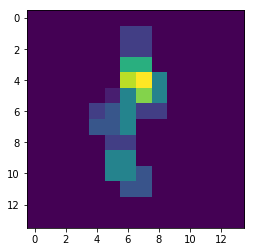

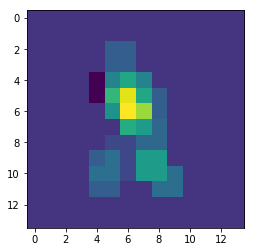

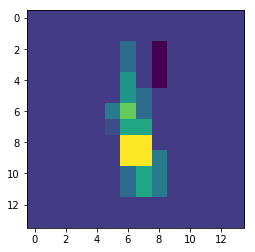

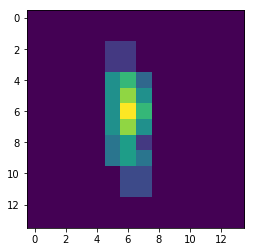

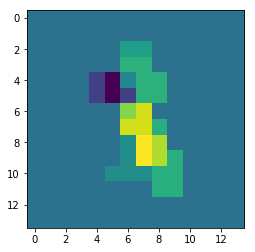

In [4]:
with tf.Session() as sess:
    obj = openpose(batch_size=8, sess = sess)
    batch_img, heatmap, vectormap, countmap = obj.test()
np.shape(batch_img)
for i in range(8):
    plt.imshow(batch_img[i])
    plt.show()
np.shape(heatmap)
heatmap = np.transpose(heatmap, (0, 3, 1, 2))
for i in range(8):
    buffer = np.zeros((14, 14))
    for j in range(16):
        buffer = buffer + heatmap[i][j]
        
    plt.imshow(buffer)
    plt.show()
np.shape(vectormap)
vectormap = np.transpose(vectormap, (0, 3, 1, 2))
for i in range(8):
    buffer = np.zeros((14, 14))
    for j in range(32):
        buffer = buffer + vectormap[i][j]
        
    plt.imshow(buffer)
    plt.show()

output data test

In [4]:
with tf.Session() as sess:
    obj = openpose(batch_size=8, sess = sess)
    heatmap, vectormap = obj.demo_test()

open pose init complete


error: C:\projects\opencv-python\opencv\modules\imgproc\src\resize.cpp:4044: error: (-215) ssize.width > 0 && ssize.height > 0 in function cv::resize


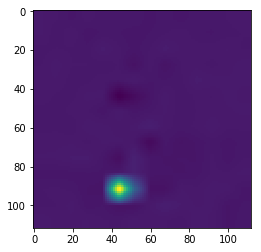

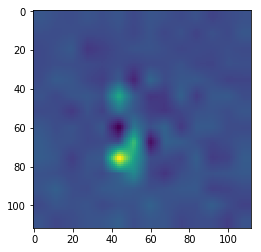

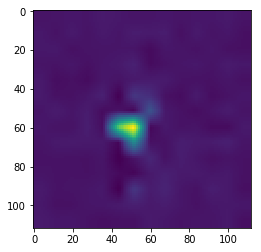

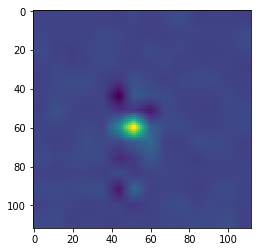

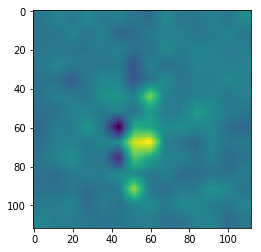

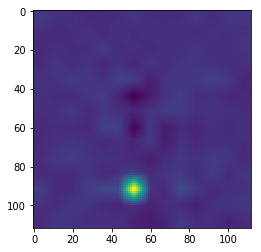

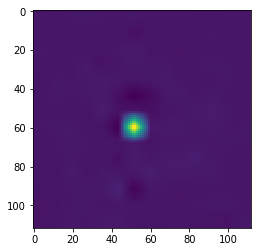

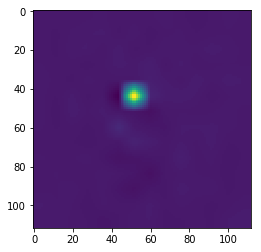

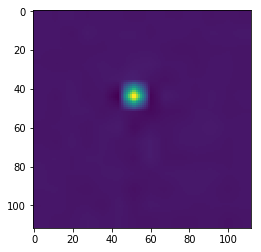

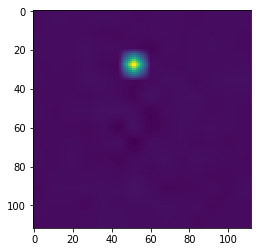

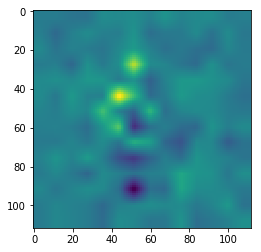

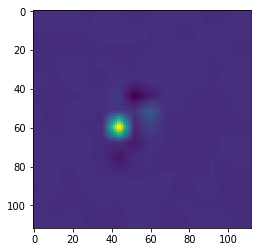

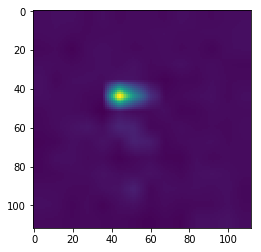

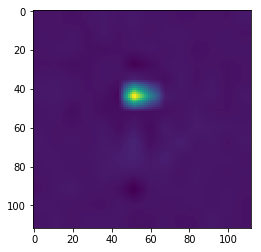

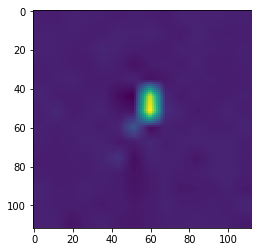

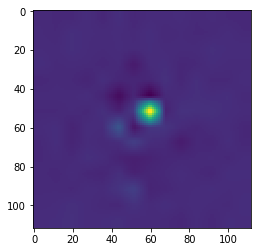

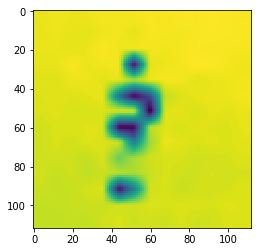

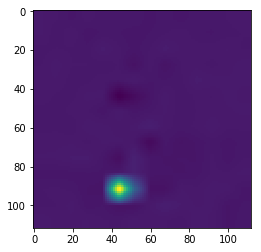

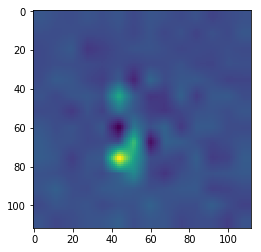

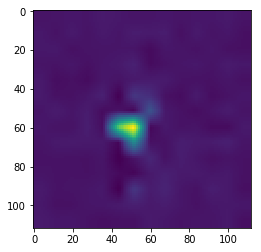

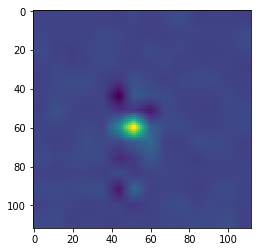

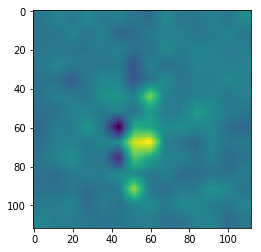

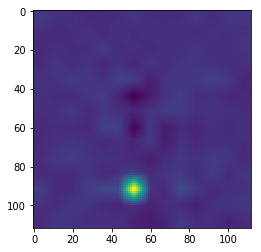

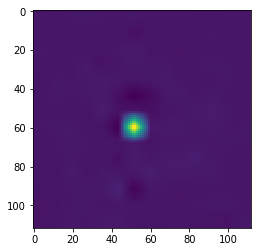

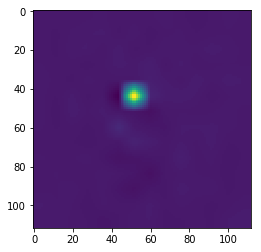

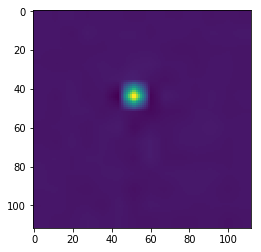

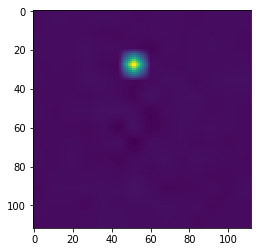

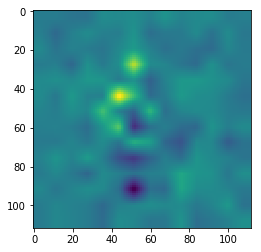

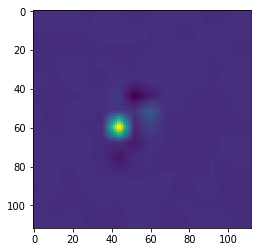

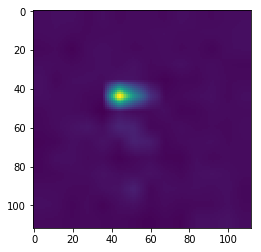

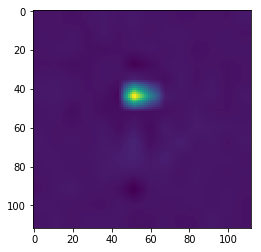

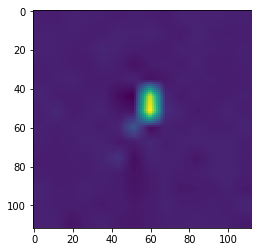

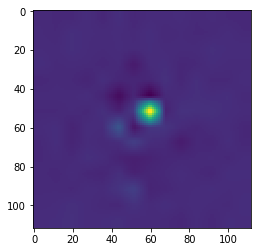

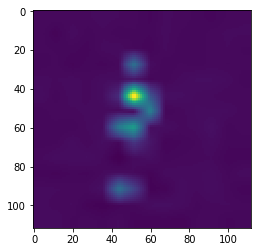

In [5]:
np.shape(heatmap)
heatmap = np.transpose(heatmap, (0, 2, 1))
output = np.zeros((17, 112, 112))
for i in range(17):
    output[i] = cv2.resize(heatmap[i], (112, 112))
    plt.imshow(output[i])
    plt.show()
    #transpose_heatmap = np.transpose(heatmap, (2, 0, 1))
##transpose_heatmap = np.squeeze(transpose_heatmap)
buff = np.zeros((112, 112))
for i in range(16):
    plt.imshow(output[i])
    plt.show()
    buff = buff + output[i]
plt.imshow(buff)
plt.show()

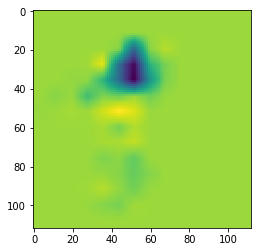

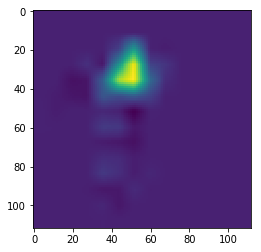

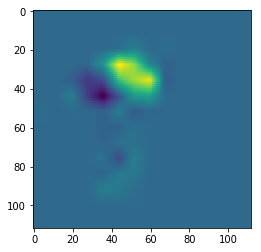

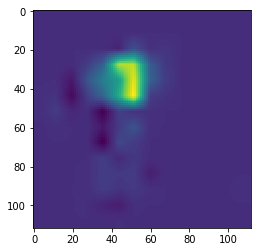

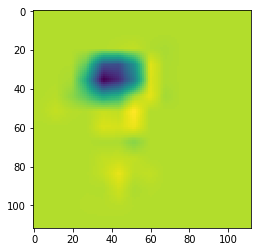

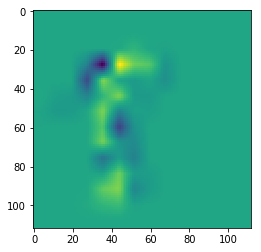

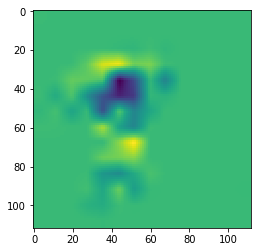

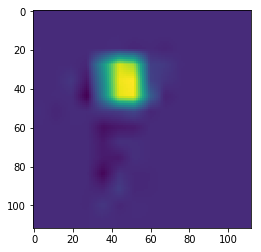

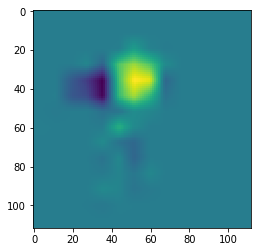

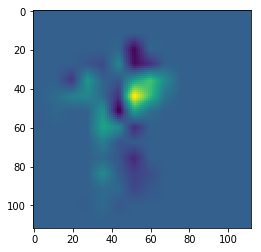

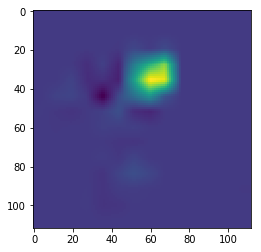

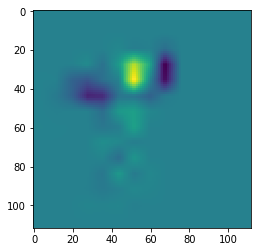

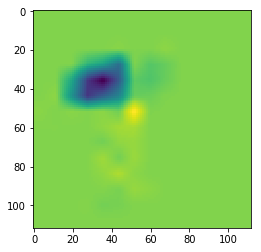

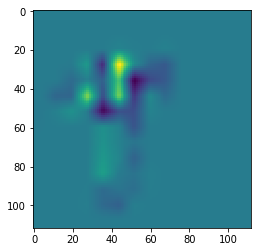

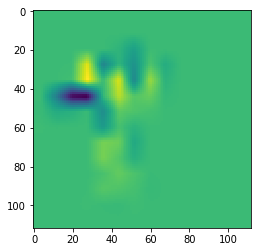

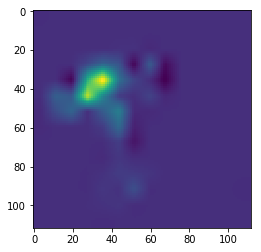

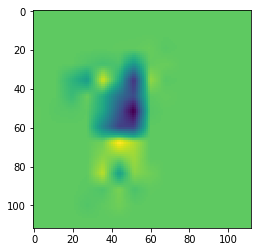

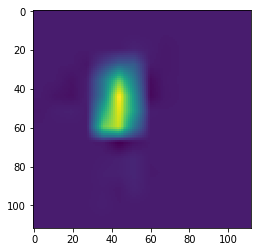

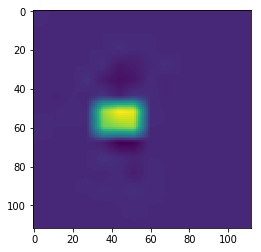

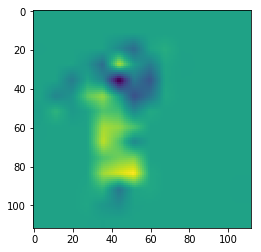

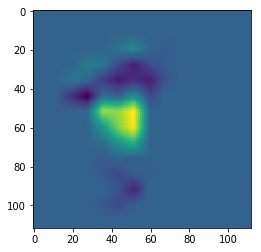

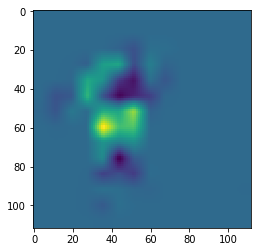

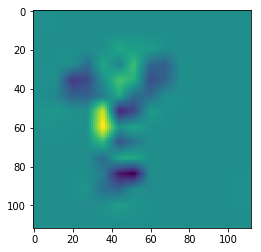

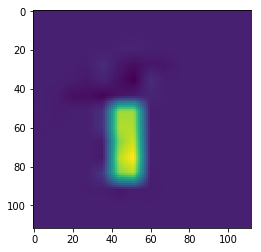

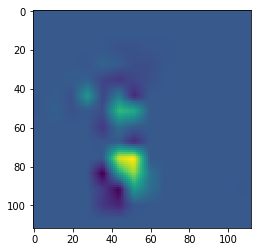

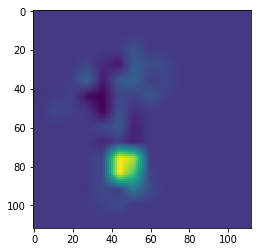

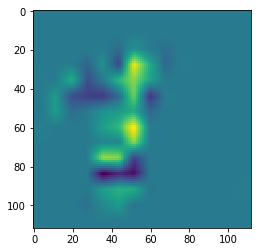

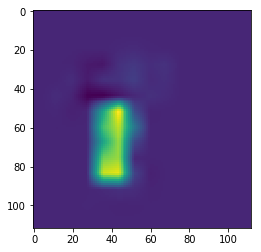

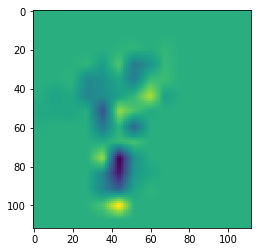

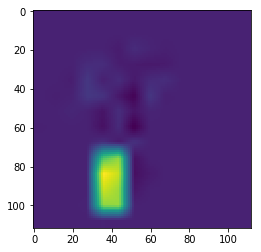

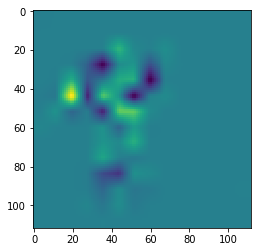

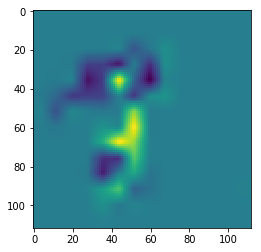

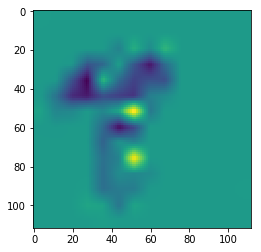

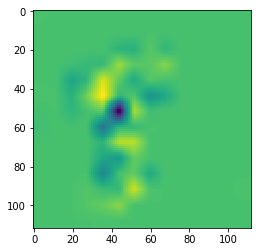

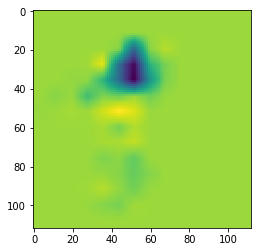

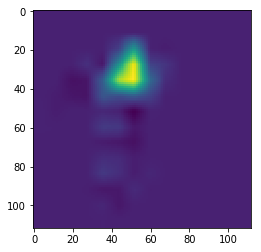

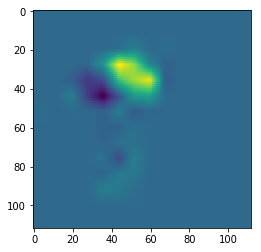

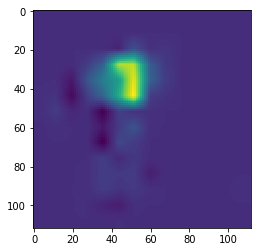

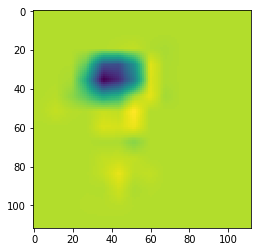

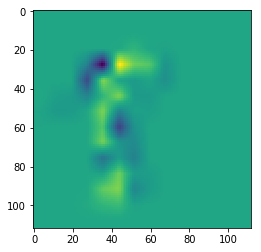

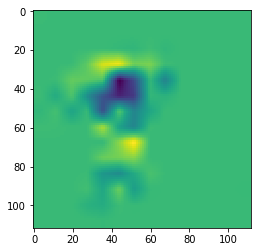

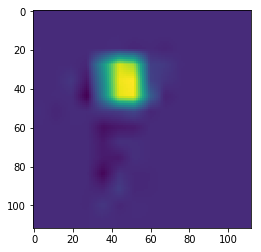

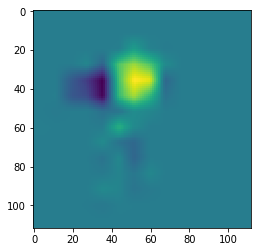

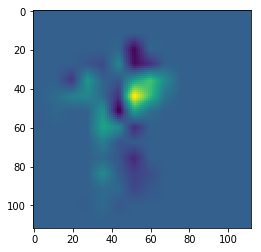

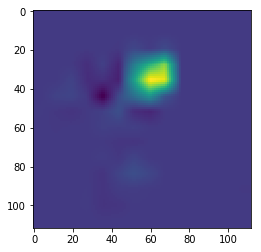

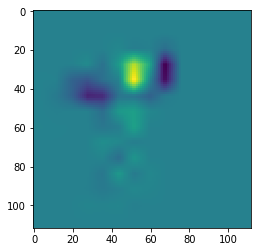

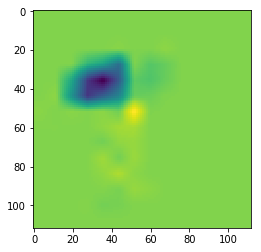

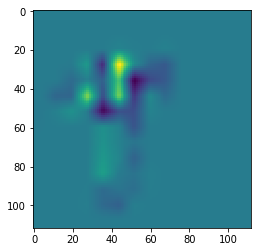

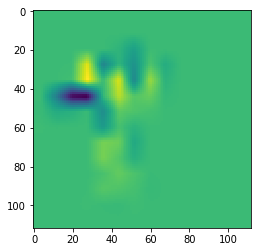

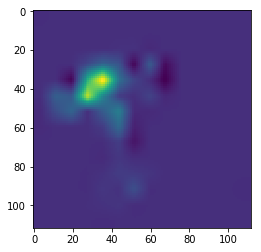

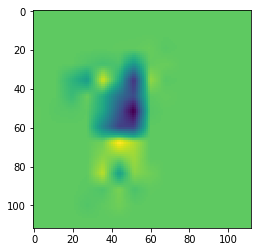

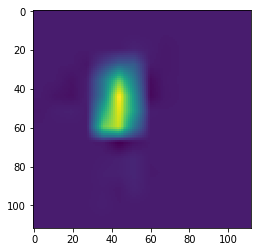

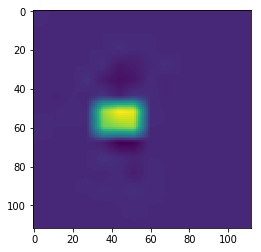

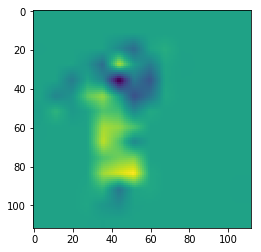

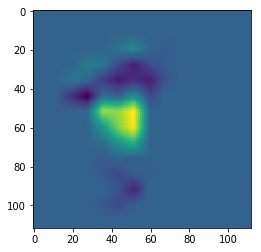

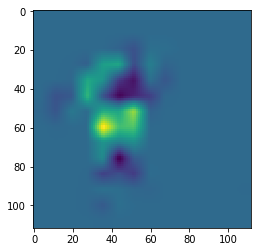

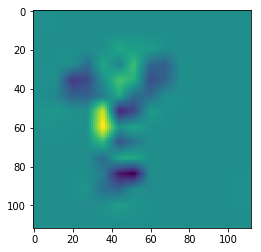

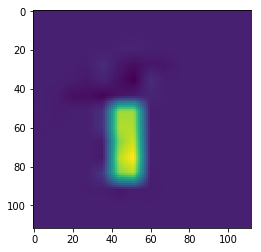

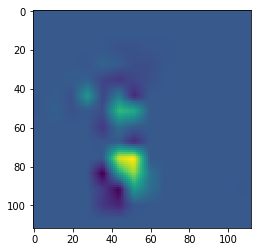

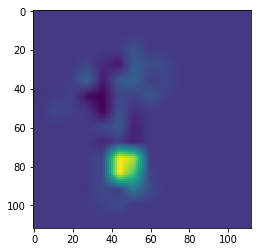

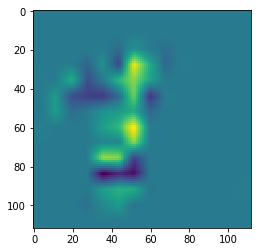

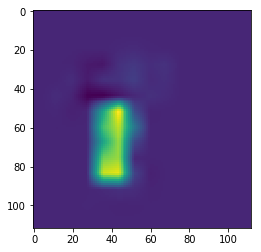

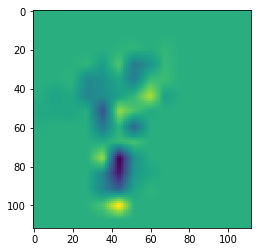

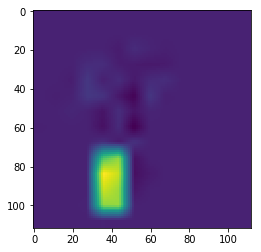

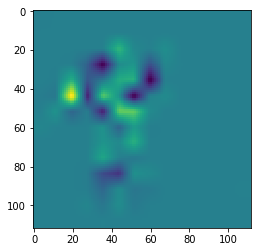

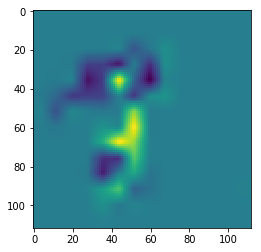

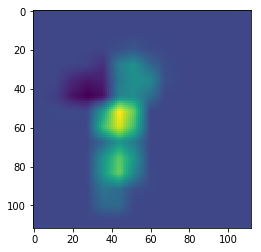

In [6]:
np.shape(vectormap)
vectormap = np.transpose(vectormap, (0, 2, 1))

output = np.zeros((34, 112, 112))
for i in range(34):
    output[i] = cv2.resize(vectormap[i], (112, 112))
    plt.imshow(output[i])
    plt.show()
#transpose_vectormap = np.transpose(vectormap, (0, 3, 1, 2))
#transpose_vectormap = np.squeeze(transpose_vectormap)
buff = np.zeros((112, 112))
for i in range(32):
    plt.imshow(output[i])
    plt.show()
    buff = buff + output[i]
plt.imshow(buff)
plt.show()

In [4]:
with tf.Session() as sess:
    obj = openpose(batch_size=30, sess = sess)
    video_data, heatmap, vectormap, label_heatmap, label_vectormap = obj.demo_test2()

open pose init complete
INFO:tensorflow:Restoring parameters from C:/Users/JAEKYU/Documents/Jupyter Notebook/Open_Pose/Weight_cmu/Weight.ckpt
weight load
['./video_with_abstacle/TrainingSet_2/test/image/left_ankle/0.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/1.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/10.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/11.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/12.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/13.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/14.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/15.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/16.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/17.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/18.jpg'
 './video_with_abstacle/TrainingSet_2/test/image/left_ankle/19.jpg'
 './video_with_abstacle/Training

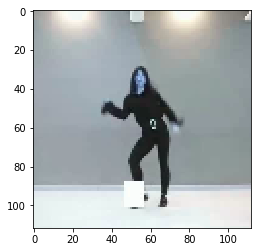

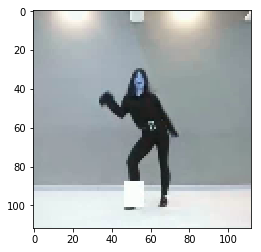

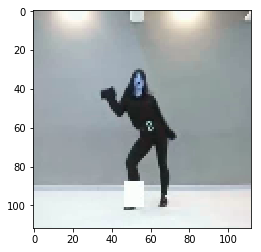

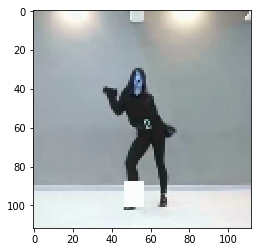

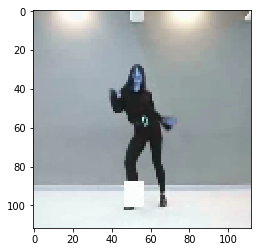

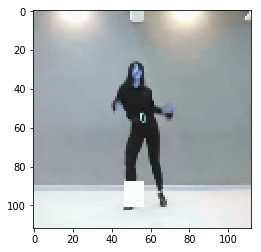

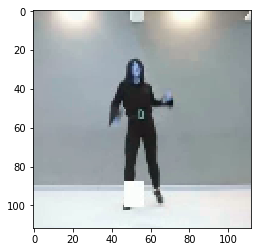

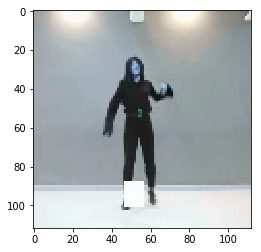

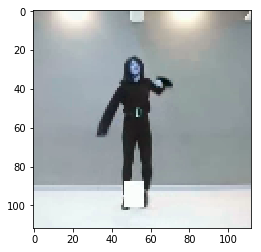

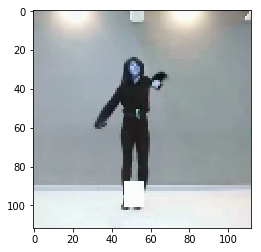

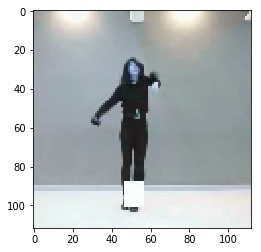

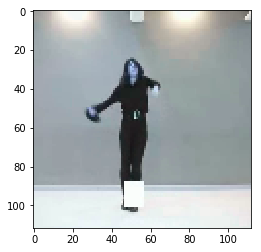

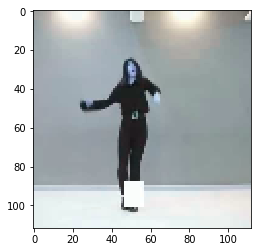

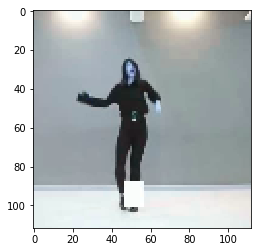

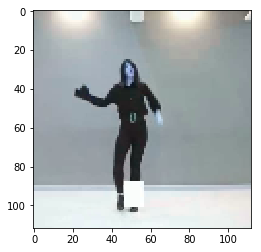

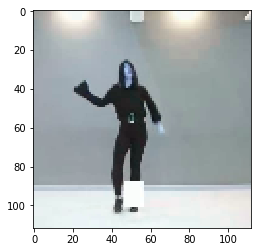

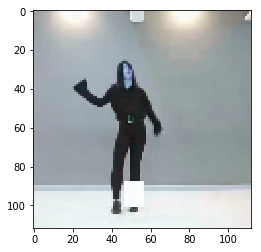

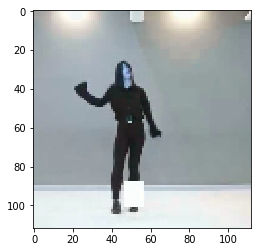

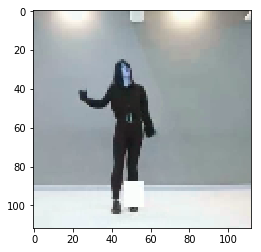

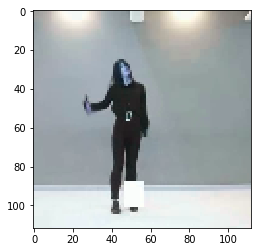

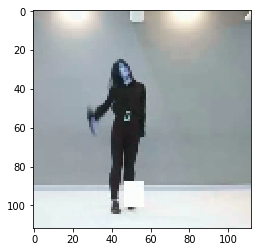

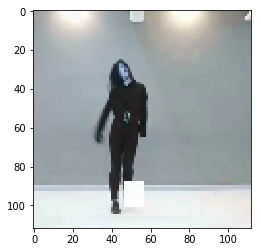

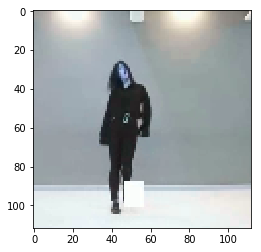

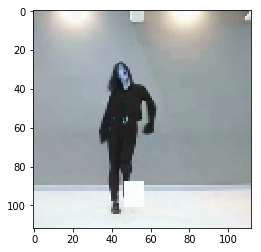

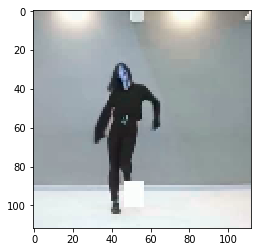

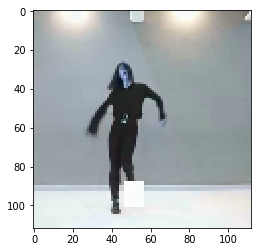

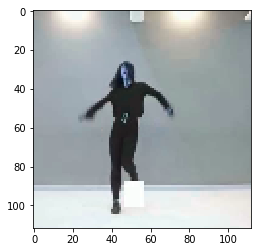

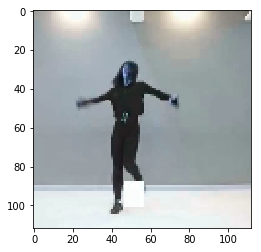

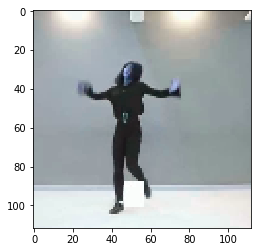

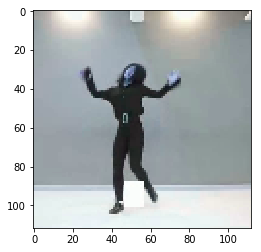

In [5]:
np.shape(video_data)
for i in range(30):
    plt.imshow(video_data[i])
    plt.show()

In [6]:
#PCKh 계산
img_index = 13

transpose_data = np.transpose(heatmap, (0, 3, 2, 1))
result1 = np.zeros((30, 16, 2))
#for i in range(30):
buffer = np.zeros((14, 14))
for i in range(30):
    for j in range(16):
        buffer = transpose_data[i][j]
        #buffer2 = cv2.resize(buffer, (112, 112))
        print(j)
        d = buffer.flatten()
        #print(np.shape(d))
        index = np.argmax(d)
        row = index//14
        col = index - (index//14)*14
        print("row, col : ", row, col)
        result1[i][j][0] = row
        result1[i][j][1] = col
        #(max(buffer))
        #plt.imshow(buffer, cmap = "bone")
        #plt.show()

0
row, col :  11 7
1
row, col :  9 6
2
row, col :  7 7
3
row, col :  7 8
4
row, col :  9 8
5
row, col :  11 8
6
row, col :  7 8
7
row, col :  5 6
8
row, col :  5 6
9
row, col :  3 6
10
row, col :  6 4
11
row, col :  6 5
12
row, col :  5 6
13
row, col :  5 7
14
row, col :  5 8
15
row, col :  6 8
0
row, col :  11 6
1
row, col :  9 6
2
row, col :  8 7
3
row, col :  7 8
4
row, col :  9 8
5
row, col :  11 8
6
row, col :  8 7
7
row, col :  5 6
8
row, col :  5 6
9
row, col :  3 6
10
row, col :  5 4
11
row, col :  6 5
12
row, col :  5 6
13
row, col :  5 7
14
row, col :  6 8
15
row, col :  7 8
0
row, col :  11 6
1
row, col :  9 6
2
row, col :  8 7
3
row, col :  7 7
4
row, col :  9 6
5
row, col :  11 8
6
row, col :  8 7
7
row, col :  5 6
8
row, col :  5 6
9
row, col :  3 6
10
row, col :  5 4
11
row, col :  6 5
12
row, col :  5 6
13
row, col :  5 7
14
row, col :  6 8
15
row, col :  8 8
0
row, col :  11 6
1
row, col :  9 6
2
row, col :  8 7
3
row, col :  7 7
4
row, col :  9 8
5
row, col :  11 8
6


In [7]:
img_index = 13
label_transpose_data = np.transpose(label_heatmap, (0, 3, 2, 1))
result2 = np.zeros((30, 16, 2))
for i in range(30):
    label_buffer = np.zeros((14, 14))
    for j in range(16):
        label_buffer = label_transpose_data[i][j]
        #buffer2 = cv2.resize(buffer, (112, 112))
        print(j)
        d = label_buffer.flatten()
        #print(np.shape(d))
        index = np.argmax(d)
        row = index//14
        col = index - (index//14)*14
        print("row, col : ", row, col)
        result2[j][0] = row
        result2[j][1] = col
        #(max(buffer))
        #plt.imshow(label_buffer, cmap = "bone")
        #plt.show()

0
row, col :  11 7
1
row, col :  9 6
2
row, col :  7 7
3
row, col :  7 8
4
row, col :  9 8
5
row, col :  11 8
6
row, col :  7 8
7
row, col :  5 6
8
row, col :  5 6
9
row, col :  3 6
10
row, col :  6 4
11
row, col :  6 5
12
row, col :  5 6
13
row, col :  5 7
14
row, col :  5 8
15
row, col :  6 8
0
row, col :  11 6
1
row, col :  9 6
2
row, col :  8 7
3
row, col :  7 8
4
row, col :  9 8
5
row, col :  11 8
6
row, col :  8 7
7
row, col :  5 6
8
row, col :  5 6
9
row, col :  3 6
10
row, col :  5 4
11
row, col :  6 5
12
row, col :  5 6
13
row, col :  5 7
14
row, col :  6 8
15
row, col :  7 8
0
row, col :  11 5
1
row, col :  9 5
2
row, col :  7 5
3
row, col :  7 6
4
row, col :  10 6
5
row, col :  12 6
6
row, col :  7 6
7
row, col :  4 6
8
row, col :  4 6
9
row, col :  2 6
10
row, col :  6 4
11
row, col :  5 5
12
row, col :  4 5
13
row, col :  4 7
14
row, col :  0 0
15
row, col :  4 7
0
row, col :  11 5
1
row, col :  10 5
2
row, col :  7 5
3
row, col :  7 6
4
row, col :  9 6
5
row, col :  11 6


In [8]:
distance_list = np.zeros((30, 16))
for batch in range(30):
    for i in range(16):
        x1 = result1[batch][i][0]
        y1 = result1[batch][i][1]

        x2 = result2[batch][i][0]
        y2 = result2[batch][i][1]

        distance = ((x1-x2)**2 + (y1-y2)**2)**0.5
        distance_list[batch][i] = distance
score = np.zeros((30, 16))
for batch in range(30):
    for i in range(16):
        if(distance_list[batch][i] < 10.5):
            score[batch][i] = True
        else:
            score[batch][i] = False
distance_list    

array([[ 4.        ,  4.12310563,  9.89949494, 10.63014581, 12.04159458,
        13.60147051, 10.63014581,  7.81024968,  7.81024968,  6.70820393,
         7.21110255,  7.81024968,  7.81024968,  8.60232527,  9.43398113,
        10.        ],
       [ 3.60555128,  3.        , 10.63014581, 10.63014581, 12.04159458,
        13.60147051, 10.63014581,  7.81024968,  7.81024968,  6.70820393,
         6.40312424,  7.81024968,  7.81024968,  8.60232527, 10.        ,
        10.63014581],
       [ 4.12310563,  3.        , 10.63014581,  9.89949494, 10.81665383,
        13.60147051, 10.63014581,  7.81024968,  7.81024968,  6.70820393,
         6.40312424,  7.81024968,  7.81024968,  8.60232527, 10.        ,
        11.3137085 ],
       [ 4.12310563,  3.        , 10.63014581,  9.89949494, 12.04159458,
        13.60147051,  9.89949494,  7.81024968,  7.81024968,  6.70820393,
         7.07106781,  7.07106781,  7.07106781,  8.60232527,  9.21954446,
        10.63014581],
       [ 3.60555128,  2.23606798, 10

In [9]:
#head
for i in range(16):
    score_result = 0
    for batch in range(30):
        score_result = score_result + score[batch][i]
    print("part's num : ", i, ", score : ", score_result,"PCKh : ", score_result / 30 * 100)

part's num :  0 , score :  15.0 PCKh :  50.0
part's num :  1 , score :  19.0 PCKh :  63.33333333333333
part's num :  2 , score :  27.0 PCKh :  90.0
part's num :  3 , score :  28.0 PCKh :  93.33333333333333
part's num :  4 , score :  3.0 PCKh :  10.0
part's num :  5 , score :  1.0 PCKh :  3.3333333333333335
part's num :  6 , score :  27.0 PCKh :  90.0
part's num :  7 , score :  30.0 PCKh :  100.0
part's num :  8 , score :  30.0 PCKh :  100.0
part's num :  9 , score :  30.0 PCKh :  100.0
part's num :  10 , score :  30.0 PCKh :  100.0
part's num :  11 , score :  30.0 PCKh :  100.0
part's num :  12 , score :  30.0 PCKh :  100.0
part's num :  13 , score :  30.0 PCKh :  100.0
part's num :  14 , score :  30.0 PCKh :  100.0
part's num :  15 , score :  25.0 PCKh :  83.33333333333334
